# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Дорофеев Демид Сергеевич
###### Группа: 307б
###### Датасет (ссылка): [Фондовый рынок](https://www.kaggle.com/datasets/prince7489/stock-market-dataset)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

# Датасеты на выбор (2 человека на датасет)

Нужно будет выбрать датасет и самим придумать задачу (регрессия или классификация)

* [Мошенические операции с картами](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
* [Фильмы](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
* [Рак молочной железы](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)
* [Кодвид](https://www.kaggle.com/datasets/imdevskp/corona-virus-report)
* [Футбол](https://www.kaggle.com/datasets/hugomathien/soccer)
* [Цена мобильных телефонов](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification)
* [120 лет Олимпийской истории](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results)
* [Фитнесс](https://www.kaggle.com/datasets/arashnic/fitbit)
* [Употребление алкоголя студентами](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)
* [Переносы рейсов самолетов](https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv)
* [Покемоны](https://www.kaggle.com/datasets/abcsds/pokemon)
* [Формула 1](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
* [Набор данных сердечно сосудистых заболеваний](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)
* [Spotify](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023)
* [Качество воды](https://www.kaggle.com/datasets/adityakadiwal/water-potability)
* [Цена на машину](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)
* [Женщины и одежда](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)
* [Факторы успеваемости студентов](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors)
* [Продукты](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [Видео игры](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [Машины](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [BMW продажи](https://www.kaggle.com/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024)
* [Землетрясения](https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset)
* [Медицинские коляски](https://www.kaggle.com/datasets/jaderz/hospital-beds-management)
* [Фондовый рынок](https://www.kaggle.com/datasets/prince7489/stock-market-dataset)
* [Steam](https://www.kaggle.com/datasets/lunthu/steam-monthly-average-players)
* [Anime](https://www.kaggle.com/datasets/neelagiriaditya/anime-dataset-jan-1917-to-oct-2025)
* [YouTube](https://www.kaggle.com/datasets/neelagiriaditya/anime-dataset-jan-1917-to-oct-2025)
* [Электрички](https://www.kaggle.com/datasets/alamshihab075/electric-vehicle-population-dataset)


# Сроки

- до 17.11.25 оценка 5
- до 24.11.25 оценка 4

# Формат сдачи

1. Защита преподавателю
2. Презентация о проделанной работе (10-15 слайдов)
3. Файл `FIO_lr3.ibynb`

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 34

lag_days = 0

In [2]:
# dataframe = pd.read_csv("random_stock_market_dataset.csv")
dataframe = pd.read_csv("HistoricalQuotes.csv")
dataframe = dataframe[::-1]
# dataframe = pd.read_csv("Tesla.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 2517 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2518 non-null   object 
 1   Close   2518 non-null   float64
 2   Volume  2518 non-null   int64  
 3   Open    2518 non-null   float64
 4   High    2518 non-null   float64
 5   Low     2518 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.2+ KB


In [3]:
# Создание признаков и целевой переменной
def prepare_data(df: pd.DataFrame, lag_days=10) -> pd.DataFrame:
    data = df.copy()
    
    # Лаги для всех признаков
    if lag_days!=0:
        for i in range(1, lag_days + 1):
            data_copy = data.copy()
            data[f'Close_lag_{i}'] = data_copy['Close'].shift(i)
            data[f'Volume_lag_{i}'] = data_copy['Volume'].shift(i)
            data[f'High_lag_{i}'] = data_copy['High'].shift(i)
            data[f'Low_lag_{i}'] = data_copy['Low'].shift(i)
    
    data_copy = data.copy()
    # Технические индикаторы
    data['Price_Range'] = data['High'] - data['Low']
    data['Price_Momentum'] = data['Close'] - data_copy['Close'].shift(3)
    
    # Целевая переменная для регрессии
    data['Next_Close'] = data['Close'].shift(-1)
    
    # Целевая переменная для классификации (будет вычислена позже)
    data['Next_Direction'] = (data['Next_Close'] > data['Close']).astype(int)
    
    return data.dropna()

# Подготовка данных

prepared_data = prepare_data(dataframe, lag_days=lag_days)

# del prepared_data['High']
# del prepared_data['Low']
# del prepared_data['Price_Range']
# del prepared_data['Price_Momentum']

try:
    del prepared_data['AdjClose']
except:
    pass

prepared_data.head(5)

,Date,Close,Volume,Open,High,Low,Price_Range,Price_Momentum,Next_Close,Next_Direction
2514,03/04/2010,30.1014,89591907,29.8971,30.1314,29.8043,0.3271,0.2457,31.2786,1
2513,03/05/2010,31.2786,224647427,30.7057,31.3857,30.6614,0.7243,1.4429,31.2971,1
2512,03/08/2010,31.2971,107326832,31.4300,31.4414,31.1786,0.2628,1.3928,31.8600,1
2511,03/09/2010,31.8600,229908139,31.1871,32.1428,31.1271,1.0157,1.7586,32.1200,1
2510,03/10/2010,32.1200,148907755,31.9757,32.2114,31.8857,0.3257,0.8414,32.2143,1


#### 2.3.2. Создание методов для отрисовки и обработки данных

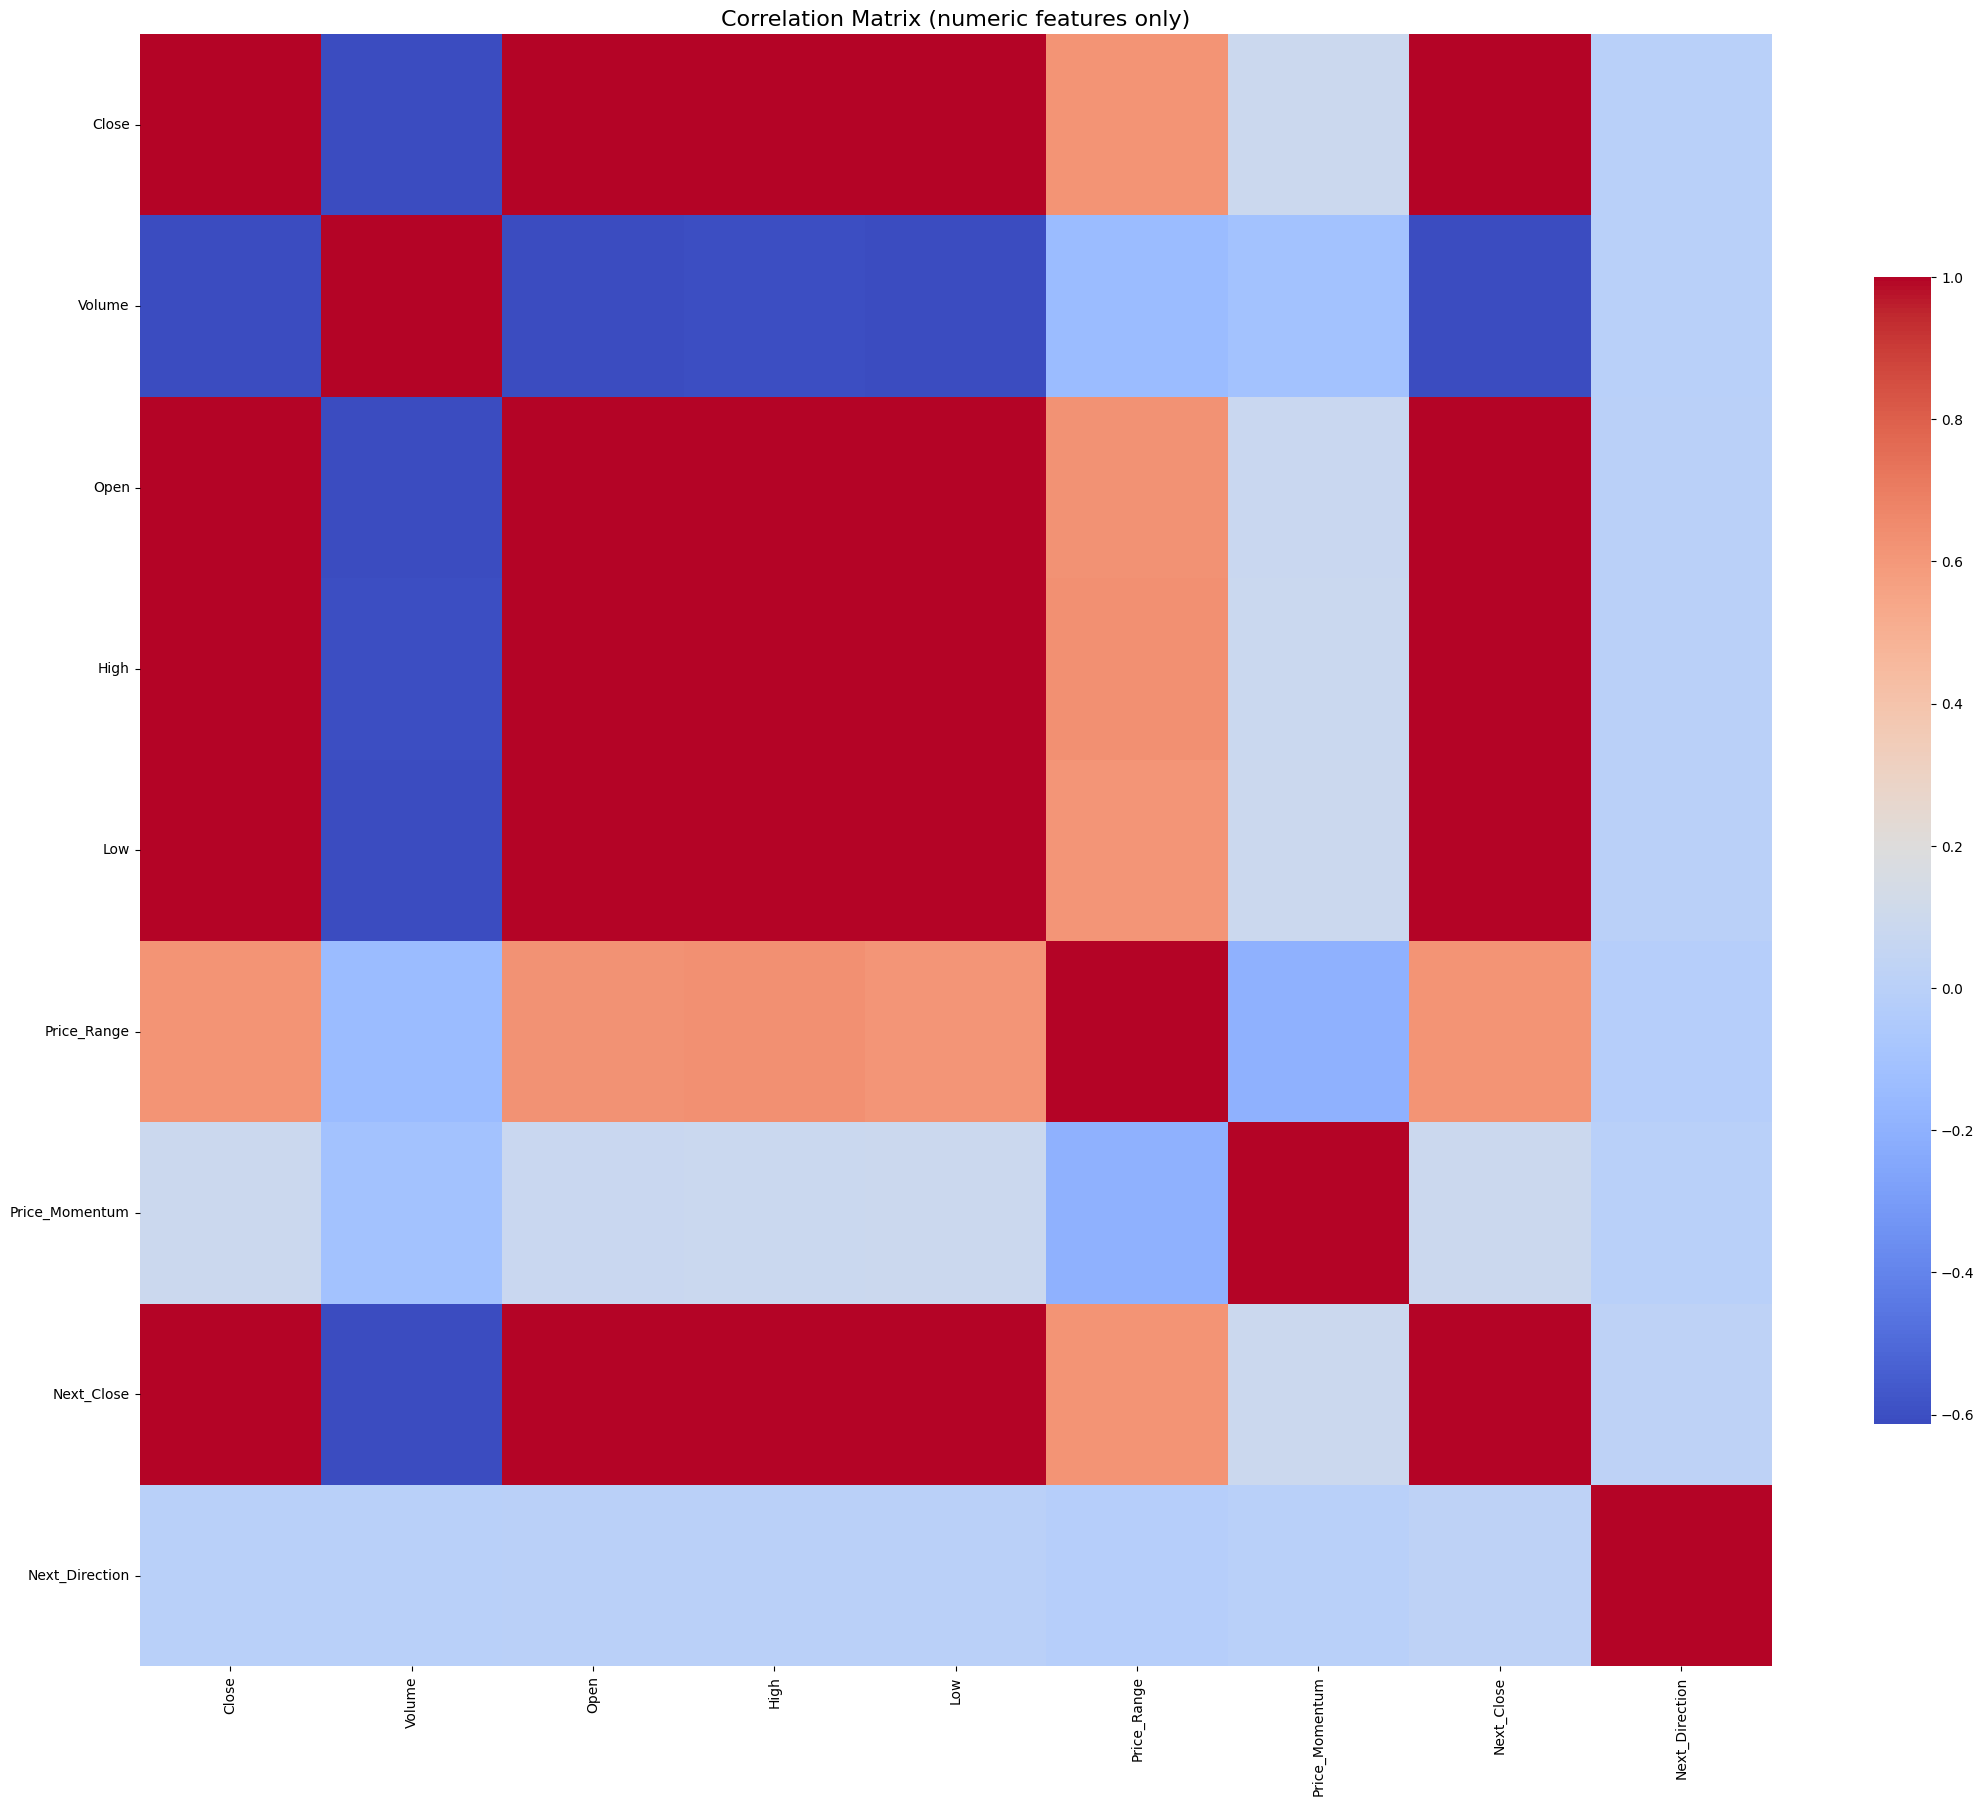

,count,mean,std,min,25%,50%,75%,max
Close,2514.0,1.148078e+02,6.055716e+01,3.010140e+01,6.691038e+01,1.011450e+02,1.546300e+02,3.272000e+02
Volume,2514.0,7.250529e+07,5.663920e+07,1.136205e+07,3.049277e+07,5.286560e+07,9.828344e+07,4.624423e+08
Open,2514.0,1.147732e+02,6.045704e+01,2.989710e+01,6.699610e+01,1.012400e+02,1.546100e+02,3.247400e+02
High,2514.0,1.158041e+02,6.102510e+01,3.013140e+01,6.773108e+01,1.021550e+02,1.557350e+02,3.278500e+02
Low,2514.0,1.137342e+02,5.999514e+01,2.846430e+01,6.644390e+01,1.004250e+02,1.533250e+02,3.233500e+02
Price_Range,2514.0,2.069854e+00,1.654724e+00,1.800000e-01,1.023250e+00,1.580000e+00,2.570000e+00,1.680000e+01
Price_Momentum,2514.0,3.041584e-01,3.592376e+00,-3.222000e+01,-1.183225e+00,3.360000e-01,1.910000e+00,1.770000e+01
Next_Close,2514.0,1.149045e+02,6.061607e+01,3.127860e+01,6.699785e+01,1.012450e+02,1.548750e+02,3.272000e+02
Next_Direction,2514.0,5.278441e-01,4.993234e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_corr_matrix(df):
    corr = df.select_dtypes(include=['number']).corr()
    corr = corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

    plt.figure(figsize=(22, 18))
    sns.heatmap(
        corr,
        annot=False,
        cmap="coolwarm",
        square=True,
        cbar_kws={"shrink": .7}
    )
    plt.title("Correlation Matrix (numeric features only)", fontsize=16)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


# example
draw_corr_matrix(prepared_data)
prepared_data.describe().T

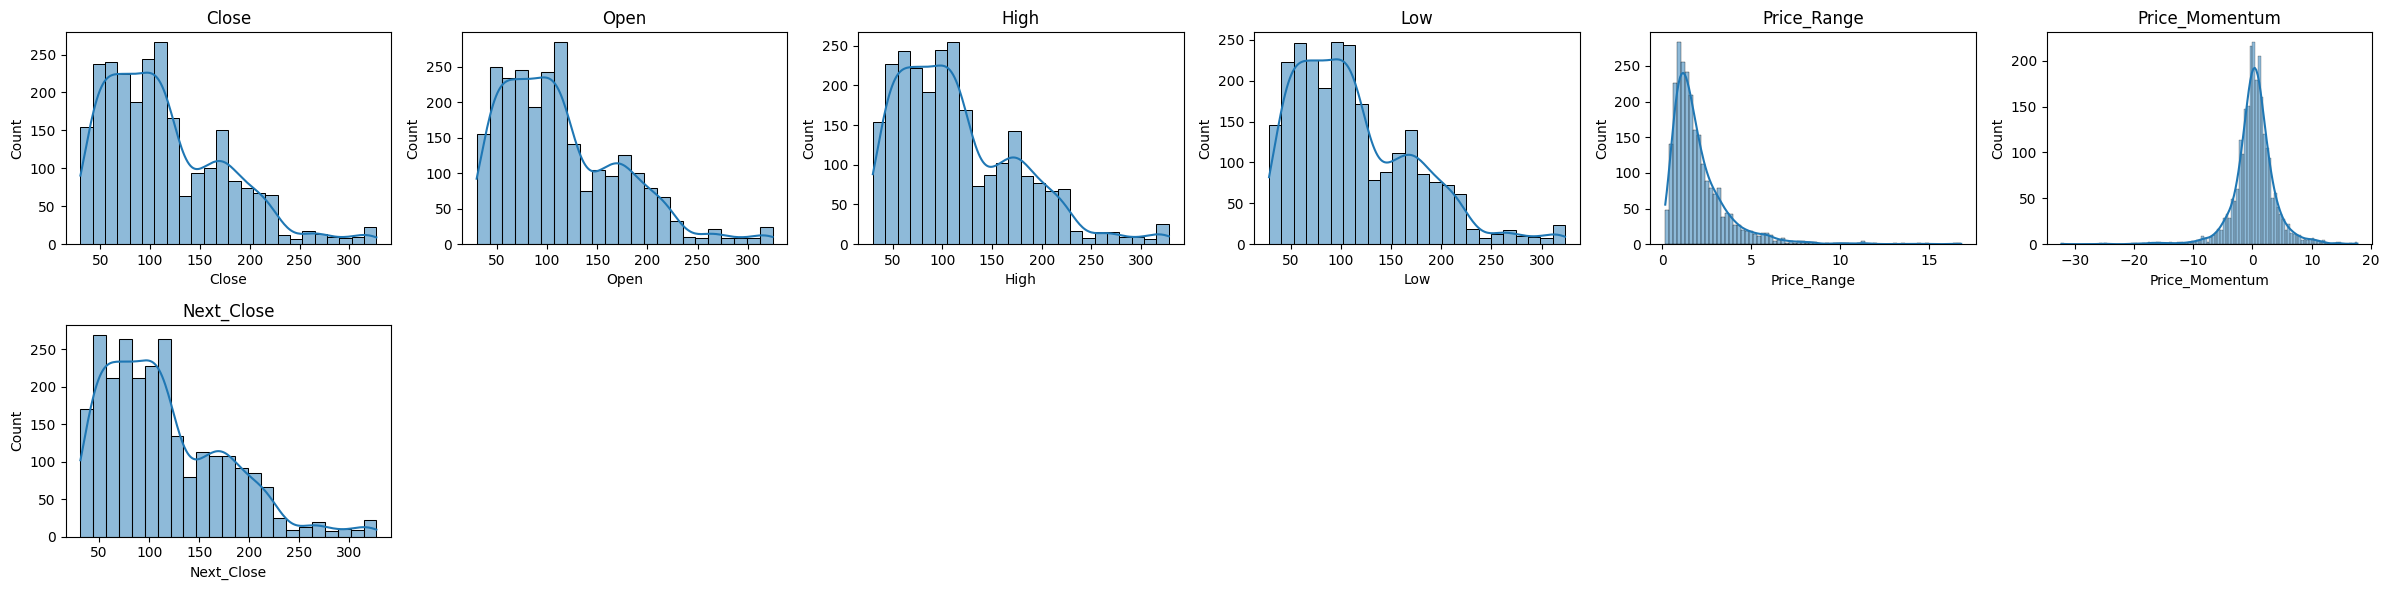

,count,mean,std,min,25%,50%,75%,max
Close,2514.0,1.148078e+02,6.055716e+01,3.010140e+01,6.691038e+01,1.011450e+02,1.546300e+02,3.272000e+02
Volume,2514.0,7.250529e+07,5.663920e+07,1.136205e+07,3.049277e+07,5.286560e+07,9.828344e+07,4.624423e+08
Open,2514.0,1.147732e+02,6.045704e+01,2.989710e+01,6.699610e+01,1.012400e+02,1.546100e+02,3.247400e+02
High,2514.0,1.158041e+02,6.102510e+01,3.013140e+01,6.773108e+01,1.021550e+02,1.557350e+02,3.278500e+02
Low,2514.0,1.137342e+02,5.999514e+01,2.846430e+01,6.644390e+01,1.004250e+02,1.533250e+02,3.233500e+02
Price_Range,2514.0,2.069854e+00,1.654724e+00,1.800000e-01,1.023250e+00,1.580000e+00,2.570000e+00,1.680000e+01
Price_Momentum,2514.0,3.041584e-01,3.592376e+00,-3.222000e+01,-1.183225e+00,3.360000e-01,1.910000e+00,1.770000e+01
Next_Close,2514.0,1.149045e+02,6.061607e+01,3.127860e+01,6.699785e+01,1.012450e+02,1.548750e+02,3.272000e+02
Next_Direction,2514.0,5.278441e-01,4.993234e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(prepared_data)
prepared_data.describe().T

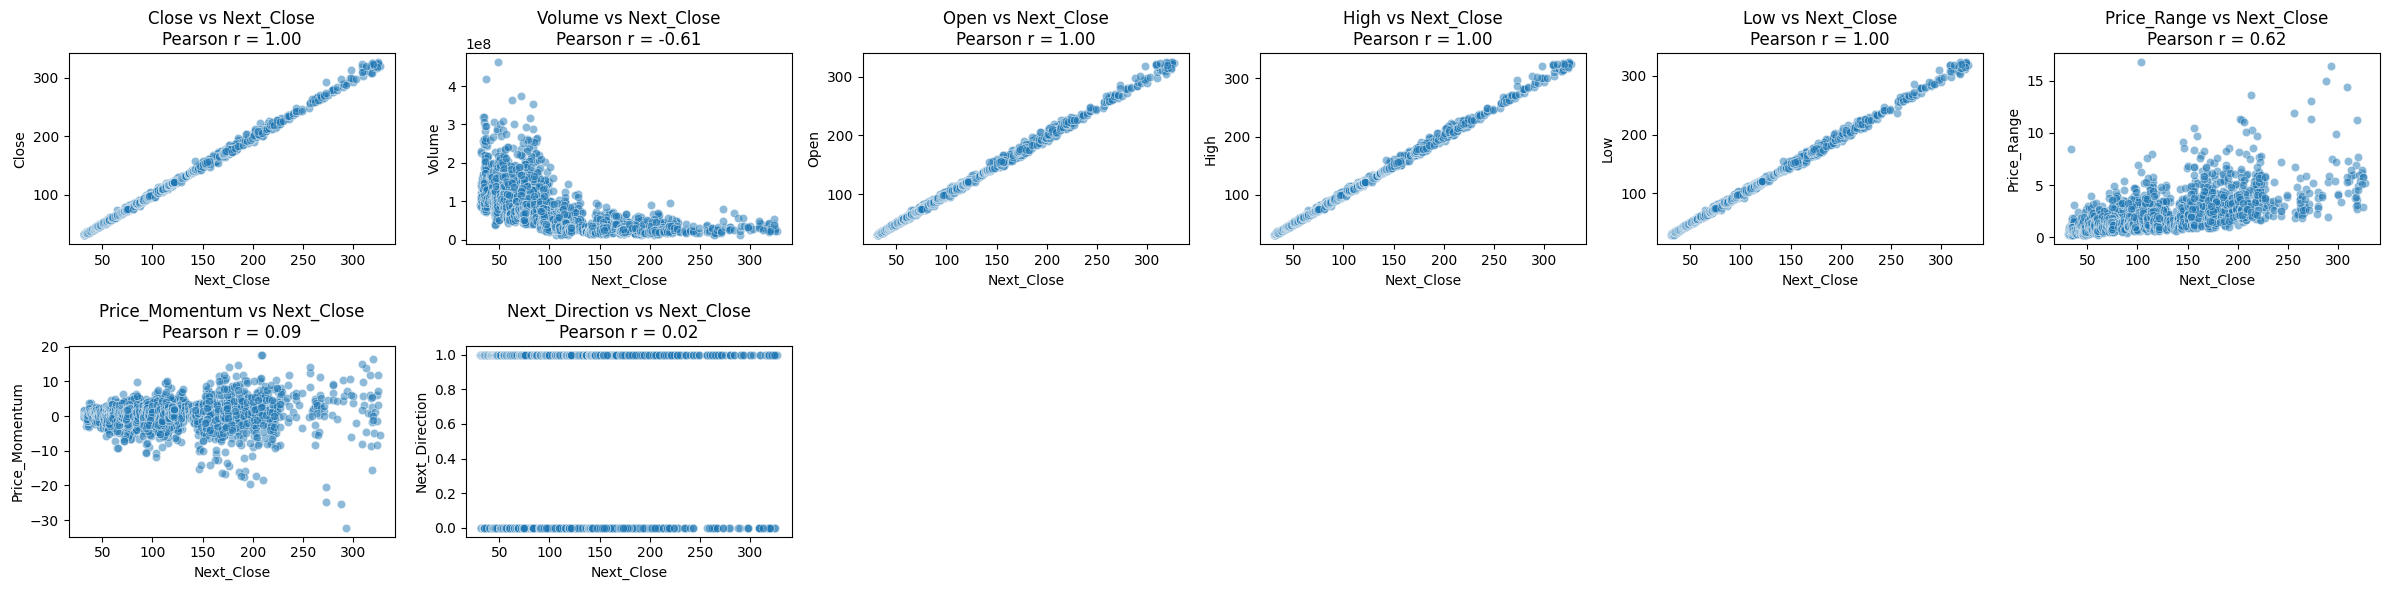

,count,mean,std,min,25%,50%,75%,max
Close,2514.0,1.148078e+02,6.055716e+01,3.010140e+01,6.691038e+01,1.011450e+02,1.546300e+02,3.272000e+02
Volume,2514.0,7.250529e+07,5.663920e+07,1.136205e+07,3.049277e+07,5.286560e+07,9.828344e+07,4.624423e+08
Open,2514.0,1.147732e+02,6.045704e+01,2.989710e+01,6.699610e+01,1.012400e+02,1.546100e+02,3.247400e+02
High,2514.0,1.158041e+02,6.102510e+01,3.013140e+01,6.773108e+01,1.021550e+02,1.557350e+02,3.278500e+02
Low,2514.0,1.137342e+02,5.999514e+01,2.846430e+01,6.644390e+01,1.004250e+02,1.533250e+02,3.233500e+02
Price_Range,2514.0,2.069854e+00,1.654724e+00,1.800000e-01,1.023250e+00,1.580000e+00,2.570000e+00,1.680000e+01
Price_Momentum,2514.0,3.041584e-01,3.592376e+00,-3.222000e+01,-1.183225e+00,3.360000e-01,1.910000e+00,1.770000e+01
Next_Close,2514.0,1.149045e+02,6.061607e+01,3.127860e+01,6.699785e+01,1.012450e+02,1.548750e+02,3.272000e+02
Next_Direction,2514.0,5.278441e-01,4.993234e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(prepared_data, target="Next_Close")
prepared_data.describe().T

In [7]:
# Сортируем данные по Date перед разделением
# prepared_data = prepared_data.sort_values('Date')

# Разделение на признаки и цели
features = [col for col in prepared_data.columns if col not in ['Next_Close', 'Next_Direction', 'Date']]
features = [col for col in prepared_data.columns if col not in ['Next_Close', 'Next_Direction', 'Date']]
X = prepared_data[features]
y = prepared_data['Next_Close']  # Для регрессии

# Временное разделение
train_size = int(0.5 * len(X))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]



# # стандартное разделение
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=RANDOM_STATE
# )


# Проверка корректности сортировки
# print("Проверка временного порядка:")
# print(f"Первая дата в train: {prepared_data['Date'].iloc[0]}")
# print(f"Последняя дата в train: {prepared_data['Date'].iloc[train_size-1]}")
# print(f"Первая дата в test: {prepared_data['Date'].iloc[train_size]}")
# print(f"Последняя дата в test: {prepared_data['Date'].iloc[-1]}")

X_train.describe()

,Close,Volume,Open,High,Low,Price_Range,Price_Momentum
count,1257.000000,1.257000e+03,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,69.076628,1.100990e+08,69.104283,69.730164,68.396026,1.334138,0.237366
std,22.447190,5.747567e+07,22.453654,22.639318,22.257402,0.832261,2.085918
min,30.101400,1.447961e+07,29.897100,30.131400,28.464300,0.180000,-9.270000
25%,50.062800,6.910941e+07,49.994300,50.464300,49.585700,0.775300,-0.914300
50%,66.888600,9.755742e+07,66.978600,67.670000,66.401400,1.164300,0.280000
75%,84.497100,1.367817e+08,84.571400,85.251400,83.628500,1.611400,1.467100
max,133.000000,4.624423e+08,132.940000,133.600000,131.170000,8.428500,9.905700


#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [8]:
from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(
    n_estimators=500,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='squared_error', # Критерий качества разбиений для каждого дерева.
                             # 'squared_error' — среднеквадратичная ошибка (по умолчанию),
                             # 'absolute_error' — средняя абсолютная ошибка,
                             # 'poisson' — для данных с распределением Пуассона.

    max_depth=10,            # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=5,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=5,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features=1.0,        # Количество признаков, используемых при поиске лучшего разбиения.
                             # 1.0 — использовать все признаки (стандарт для регрессии),
                             # 'sqrt' — корень из числа признаков,
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    min_impurity_decrease=0.0, # Минимальное уменьшение примеси для разбиения.
    
    ccp_alpha=0.0           # Параметр минимальной cost-complexity pruning.
)

In [9]:
model_forest.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

In [10]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics_regression(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }

In [11]:
predicted_prices_forest = model_forest.predict(X_test)

get_metrics_regression(y_test, predicted_prices_forest)

{'MSE': np.float64(3471.158210181774),
 'RMSE': np.float64(58.91653596556551),
 'MAE': np.float64(38.481748023208034),
 'R2': np.float64(-0.3075948030340392)}

In [12]:
def average_numpy_array(arr, n):
    # Оставляем только полные группы
    truncated_len = len(arr) // n * n
    if truncated_len == 0:
        return arr
    
    truncated_arr = arr[:truncated_len]
    # Переформатируем и вычисляем среднее
    return truncated_arr.reshape(-1, n).mean(axis=1)

def sample_every_n(arr, n):
    """
    Оставляет каждое n-е значение из массива
    
    Parameters:
    arr: numpy array или list
    n: шаг выборки
    
    Returns:
    Массив с каждым n-м элементом
    """
    return arr.copy()[::n]



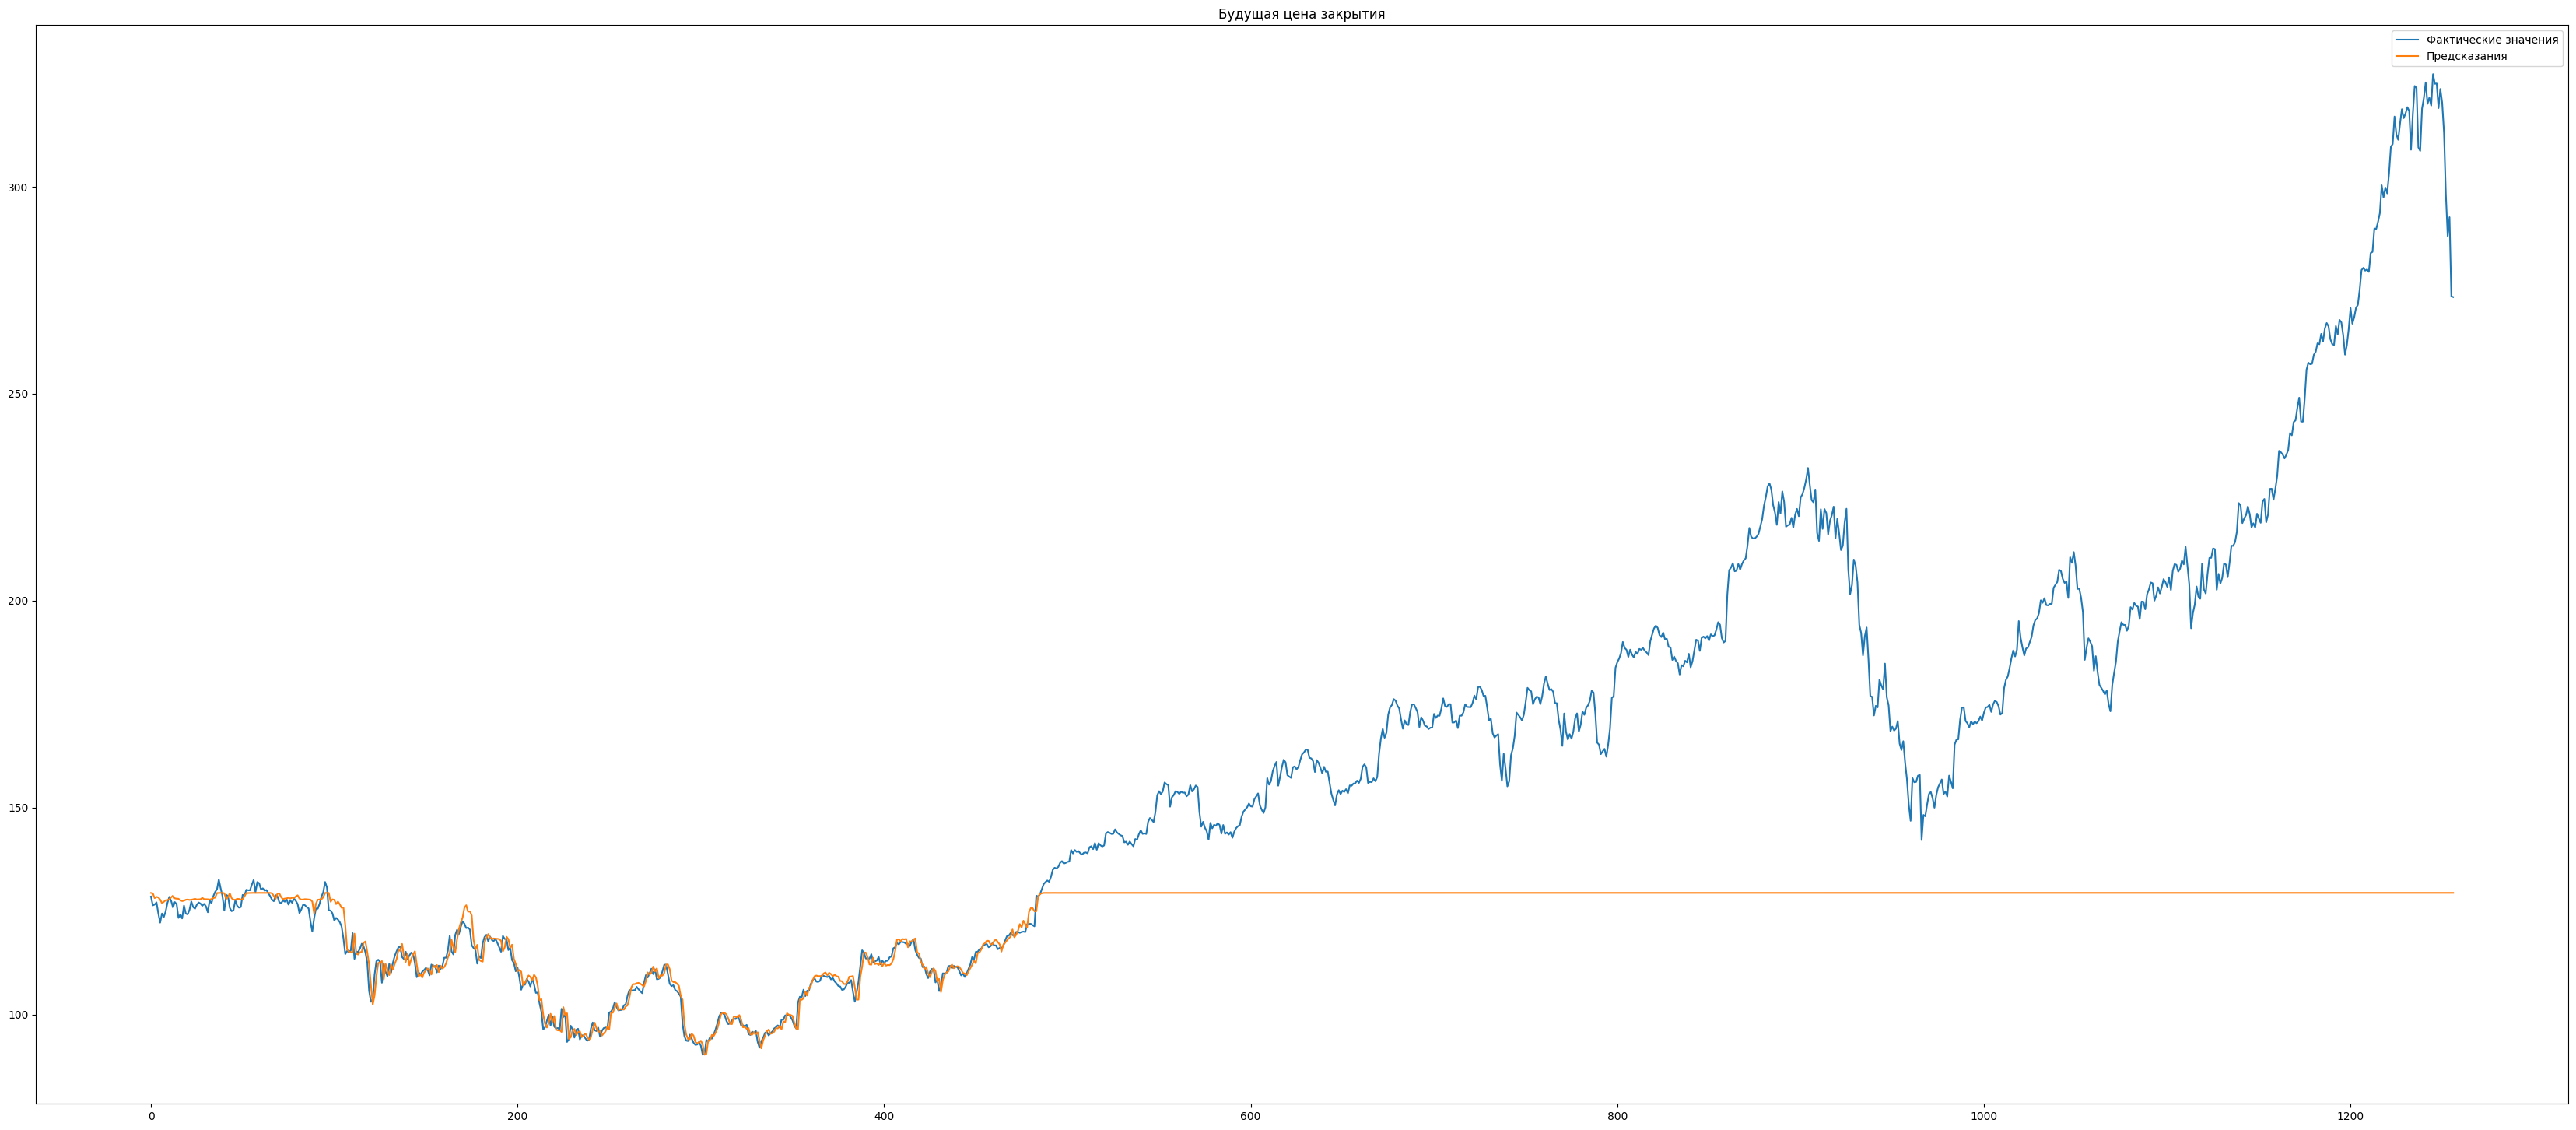

In [13]:
import matplotlib.pyplot as plt

scale = 1


def show_predict_on_test(y_test, y_pred, scale=1):
    y_test_new = sample_every_n(y_test, scale)
    y_pred_new = sample_every_n(y_pred, scale)

    plt.figure(figsize=(42, 18))
    plt.plot(y_test_new, label='Фактические значения')
    plt.plot(y_pred_new, label='Предсказания')
    plt.legend()
    plt.title('Будущая цена закрытия')
    plt.show()


show_predict_on_test(y_test.values, predicted_prices_forest, scale=scale)

In [14]:
# Более явный код
today_prices = sample_every_n(X_test['Close'].values, scale)

y_test = sample_every_n(y_test.values, scale)
y_pred = sample_every_n(predicted_prices_forest, scale)


tomorrow_actual_prices = y_test
tomorrow_predicted_prices = y_pred

# Фактическое направление (завтра vs сегодня)
actual_directions = (tomorrow_actual_prices > today_prices).astype(int)

# Предсказанное направление (предсказание завтра vs сегодня)
predicted_directions = (tomorrow_predicted_prices > today_prices).astype(int)

# Оценка качества классификации
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(actual_directions, predicted_directions)
print(f"Accuracy направления: {accuracy:.3f}")
print(confusion_matrix(actual_directions, predicted_directions))

Accuracy направления: 0.469
[[434 165]
 [503 155]]


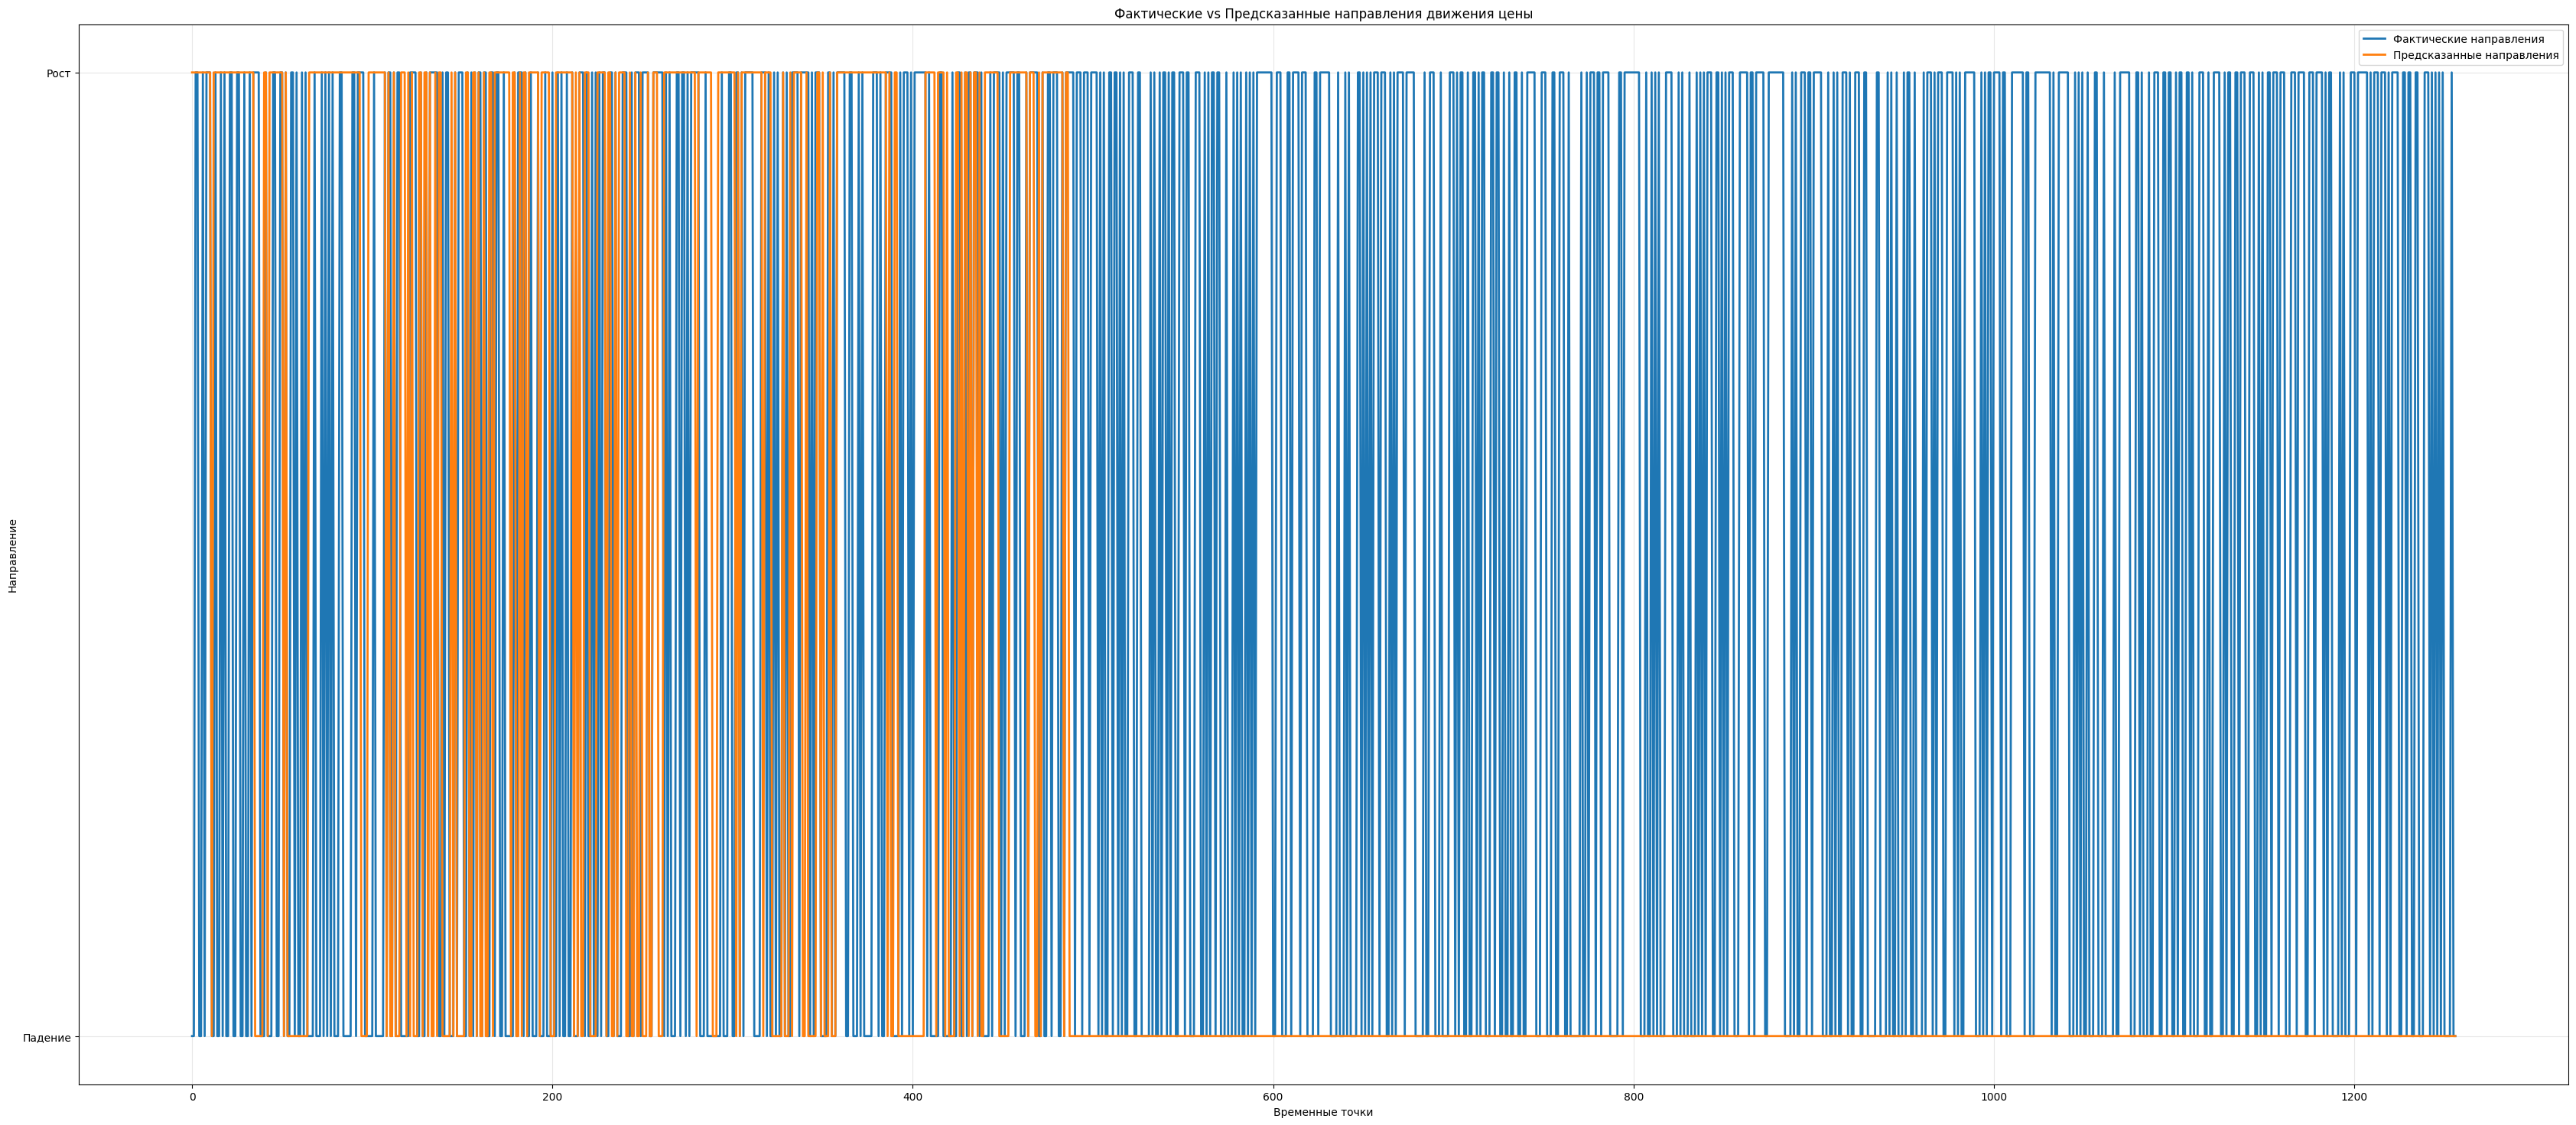

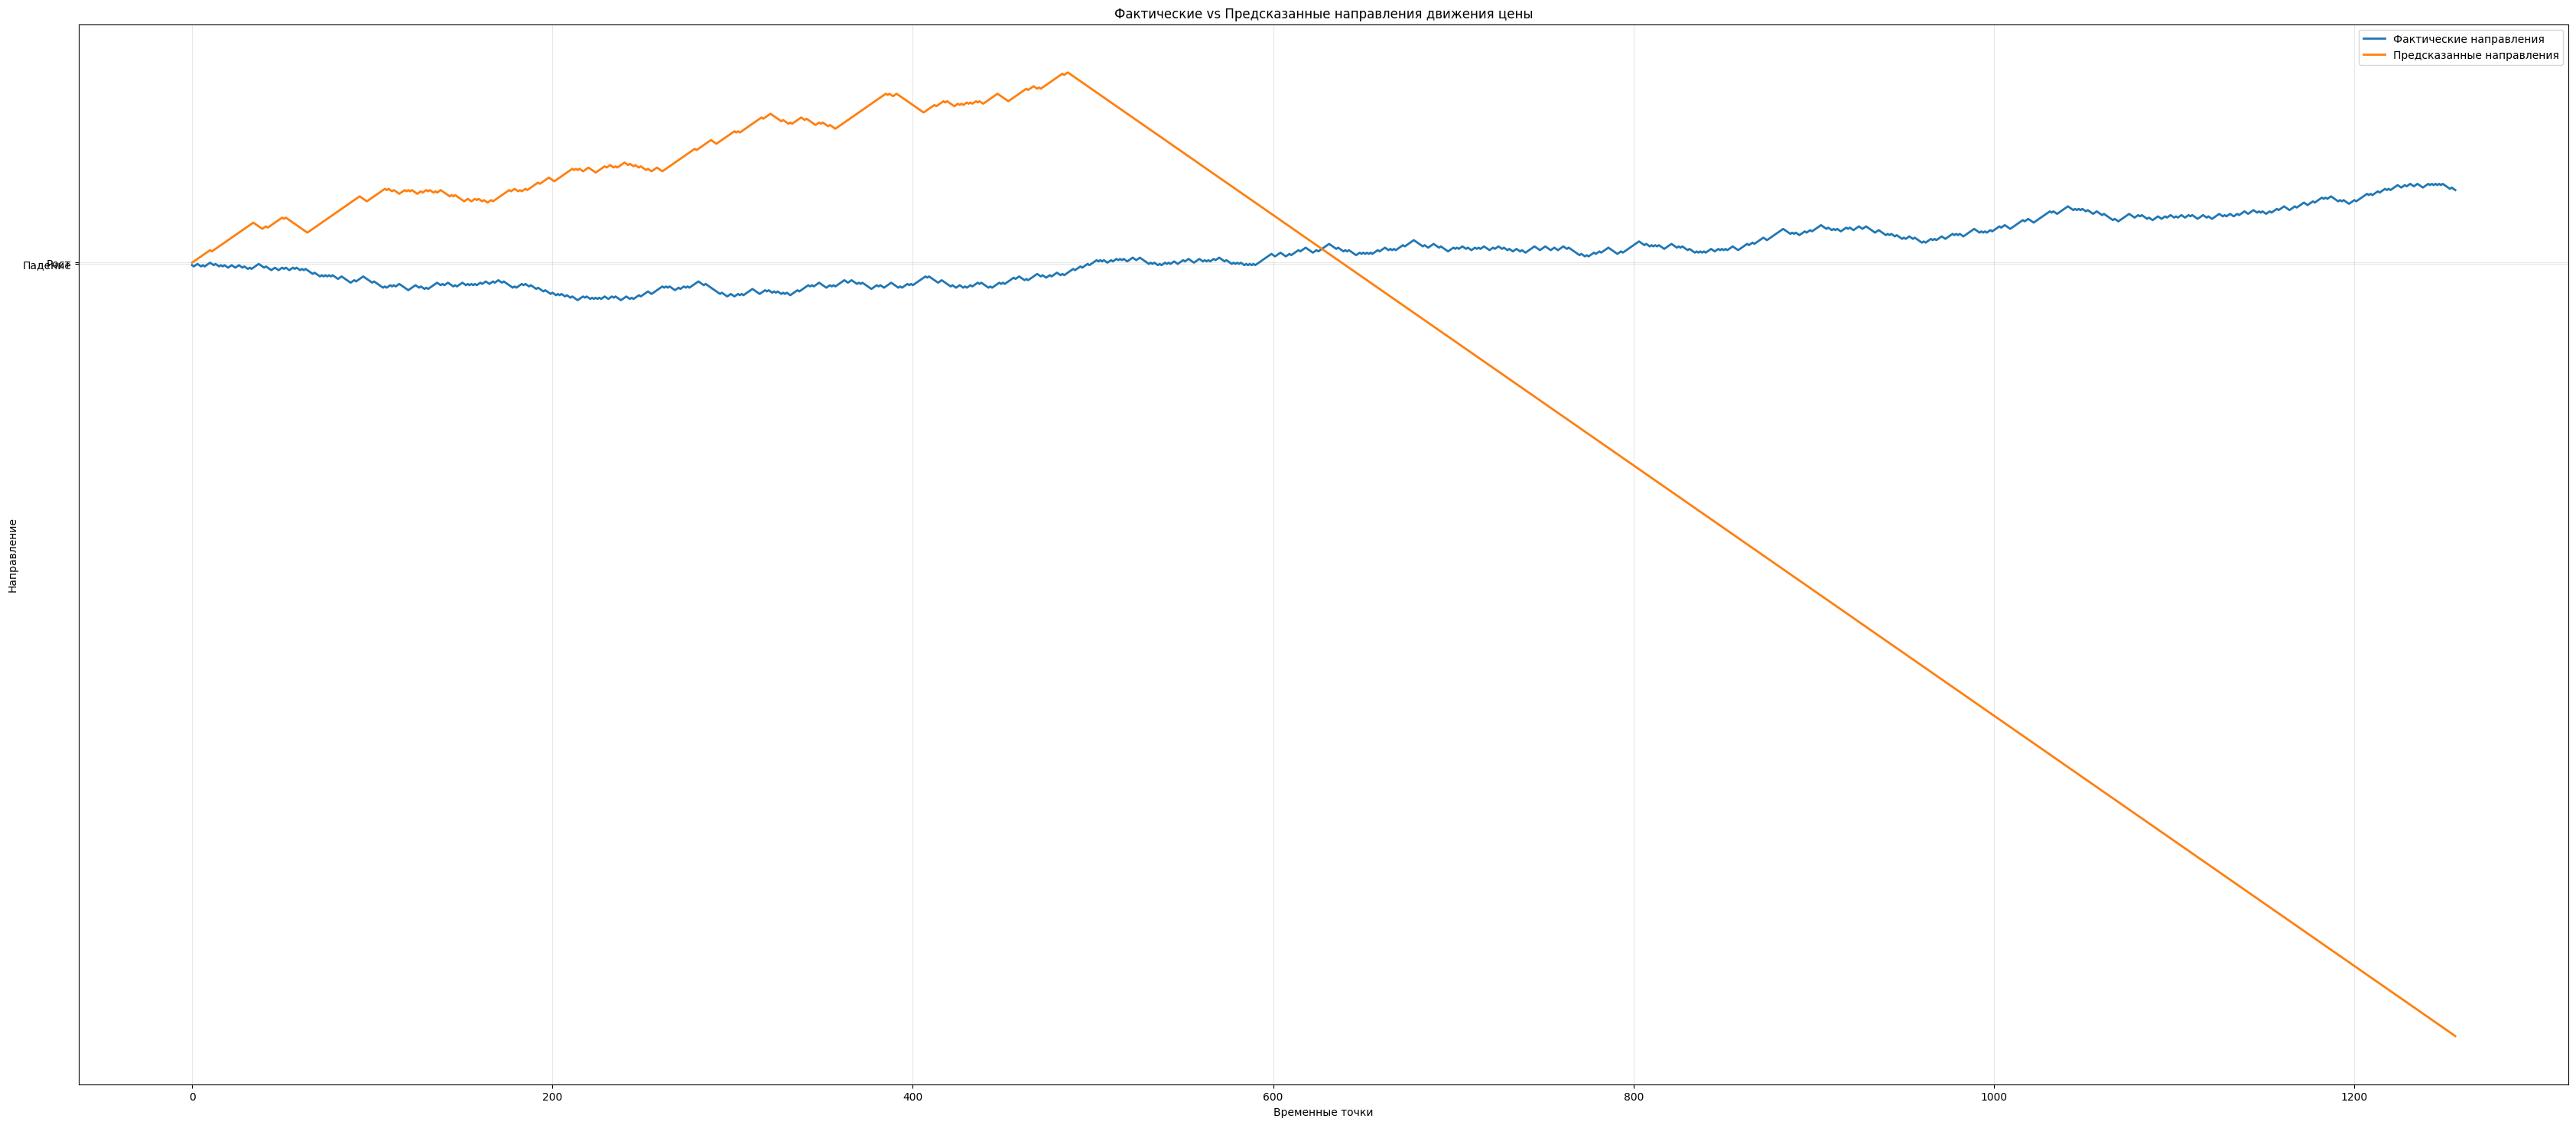

In [15]:
plt.figure(figsize=(42, 18))
plt.plot(actual_directions, label='Фактические направления', linewidth=2)
plt.plot(predicted_directions, label='Предсказанные направления', linewidth=2)
plt.yticks([0, 1], ['Падение', 'Рост'])
plt.xlabel('Временные точки')
plt.ylabel('Направление')
plt.title('Фактические vs Предсказанные направления движения цены')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


actual_graph = actual_directions.copy()
actual_graph[actual_graph == 0] = -1
for i in range(1, len(actual_graph)):
    actual_graph[i] += actual_graph[i-1]

predicted_graph = predicted_directions.copy()
predicted_graph[predicted_graph == 0] = -1
for i in range(1, len(predicted_graph)):
    predicted_graph[i] += predicted_graph[i-1]


plt.figure(figsize=(42, 18))
plt.plot(actual_graph, label='Фактические направления', linewidth=2)
plt.plot(predicted_graph, label='Предсказанные направления', linewidth=2)
plt.yticks([0, 1], ['Падение', 'Рост'])
plt.xlabel('Временные точки')
plt.ylabel('Направление')
plt.title('Фактические vs Предсказанные направления движения цены')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 99%|===================| 1243/1257 [01:29<00:01]        

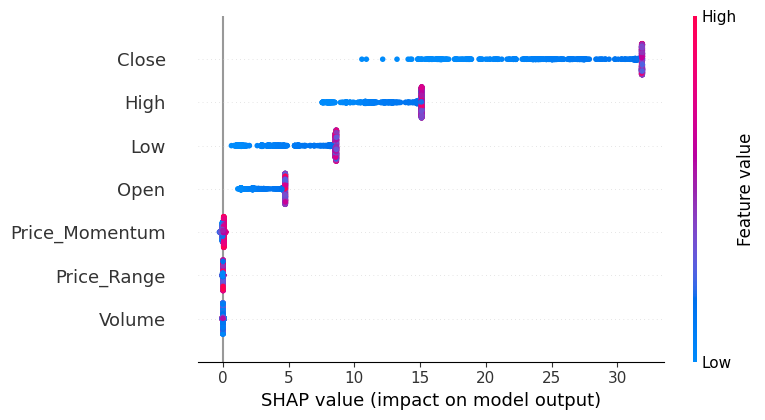

In [16]:
import shap


# Использование SHAP для случайного леса
explainer = shap.Explainer(model_forest, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Подбор гиперпараметров

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Пайплайн с масштабированием
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # масштабирование
    ('classifier', RandomForestRegressor(random_state=RANDOM_STATE))  # модель
])

# Просмотр пайплайна
pipeline

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


# Grid Search
- Перебирает все возможные комбинации указанных гиперпараметров.
- Для каждой комбинации обучает модель и проверяет качество на кросс-валидации.
- Возвращает лучшую комбинацию по заданной метрике (например, accuracy).

In [18]:
param_grid = {
    "classifier__n_estimators" : [100, 500],        
                             # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    "classifier__criterion" : ['squared_error', 'absolute_error'], 
                             # Критерий качества разбиений для каждого дерева.
                             # 'squared_error' — среднеквадратичная ошибка (по умолчанию),
                             # 'absolute_error' — средняя абсолютная ошибка,
                             # 'poisson' — для данных с распределением Пуассона.

    "classifier__max_depth" : [5, 20],            # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    "classifier__min_samples_split" : [2,5,10],    
                             # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    "classifier__min_samples_leaf" : [1, 2, 4],
                             # Минимальное количество образцов в листе.
                     
                             # Увеличение делает модель более "плавной".

    "classifier__max_features" : [1.0, 'sqrt', 'log2'],        # Количество признаков, используемых при поиске лучшего разбиения.
                             # 1.0 — использовать все признаки (стандарт для регрессии),
                             # 'sqrt' — корень из числа признаков,
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    "classifier__bootstrap" : [True, False],          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    # "classifier__n_jobs" : [None],             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    # "classifier__min_impurity_decrease" : [0.0], # Минимальное уменьшение примеси для разбиения.
    
    # "classifier__ccp_alpha" : [0.0]
}

In [19]:
from sklearn.model_selection import GridSearchCV

# Создание сетки
gs_forest = GridSearchCV(
    estimator=pipeline,     # модель
    param_grid=param_grid,  # параметры
    scoring="r2",     # метрика
    cv=3,                   # K-folds для кросс валидации
    n_jobs=-1,              # параллель на всю катушку
    verbose=3,              # кол-во информации для отображения
    refit=True
)

# Обучение моделей
gs_forest.fit(X_train, y_train)

# Результаты
print("\nЛучшие параметры:")
for key, value in gs_forest.best_params_.items():
    print(f'{key} -> {value}')
print("\nЛучшее качество на кросс-валидации:", gs_forest.best_score_)
print("Точность на тесте:", gs_forest.score(X_test, y_test))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Лучшие параметры:
classifier__bootstrap -> False
classifier__criterion -> absolute_error
classifier__max_depth -> 20
classifier__max_features -> 1.0
classifier__min_samples_leaf -> 2
classifier__min_samples_split -> 5
classifier__n_estimators -> 100

Лучшее качество на кросс-валидации: 0.2179670962329772
Точность на тесте: -0.25763826109186505


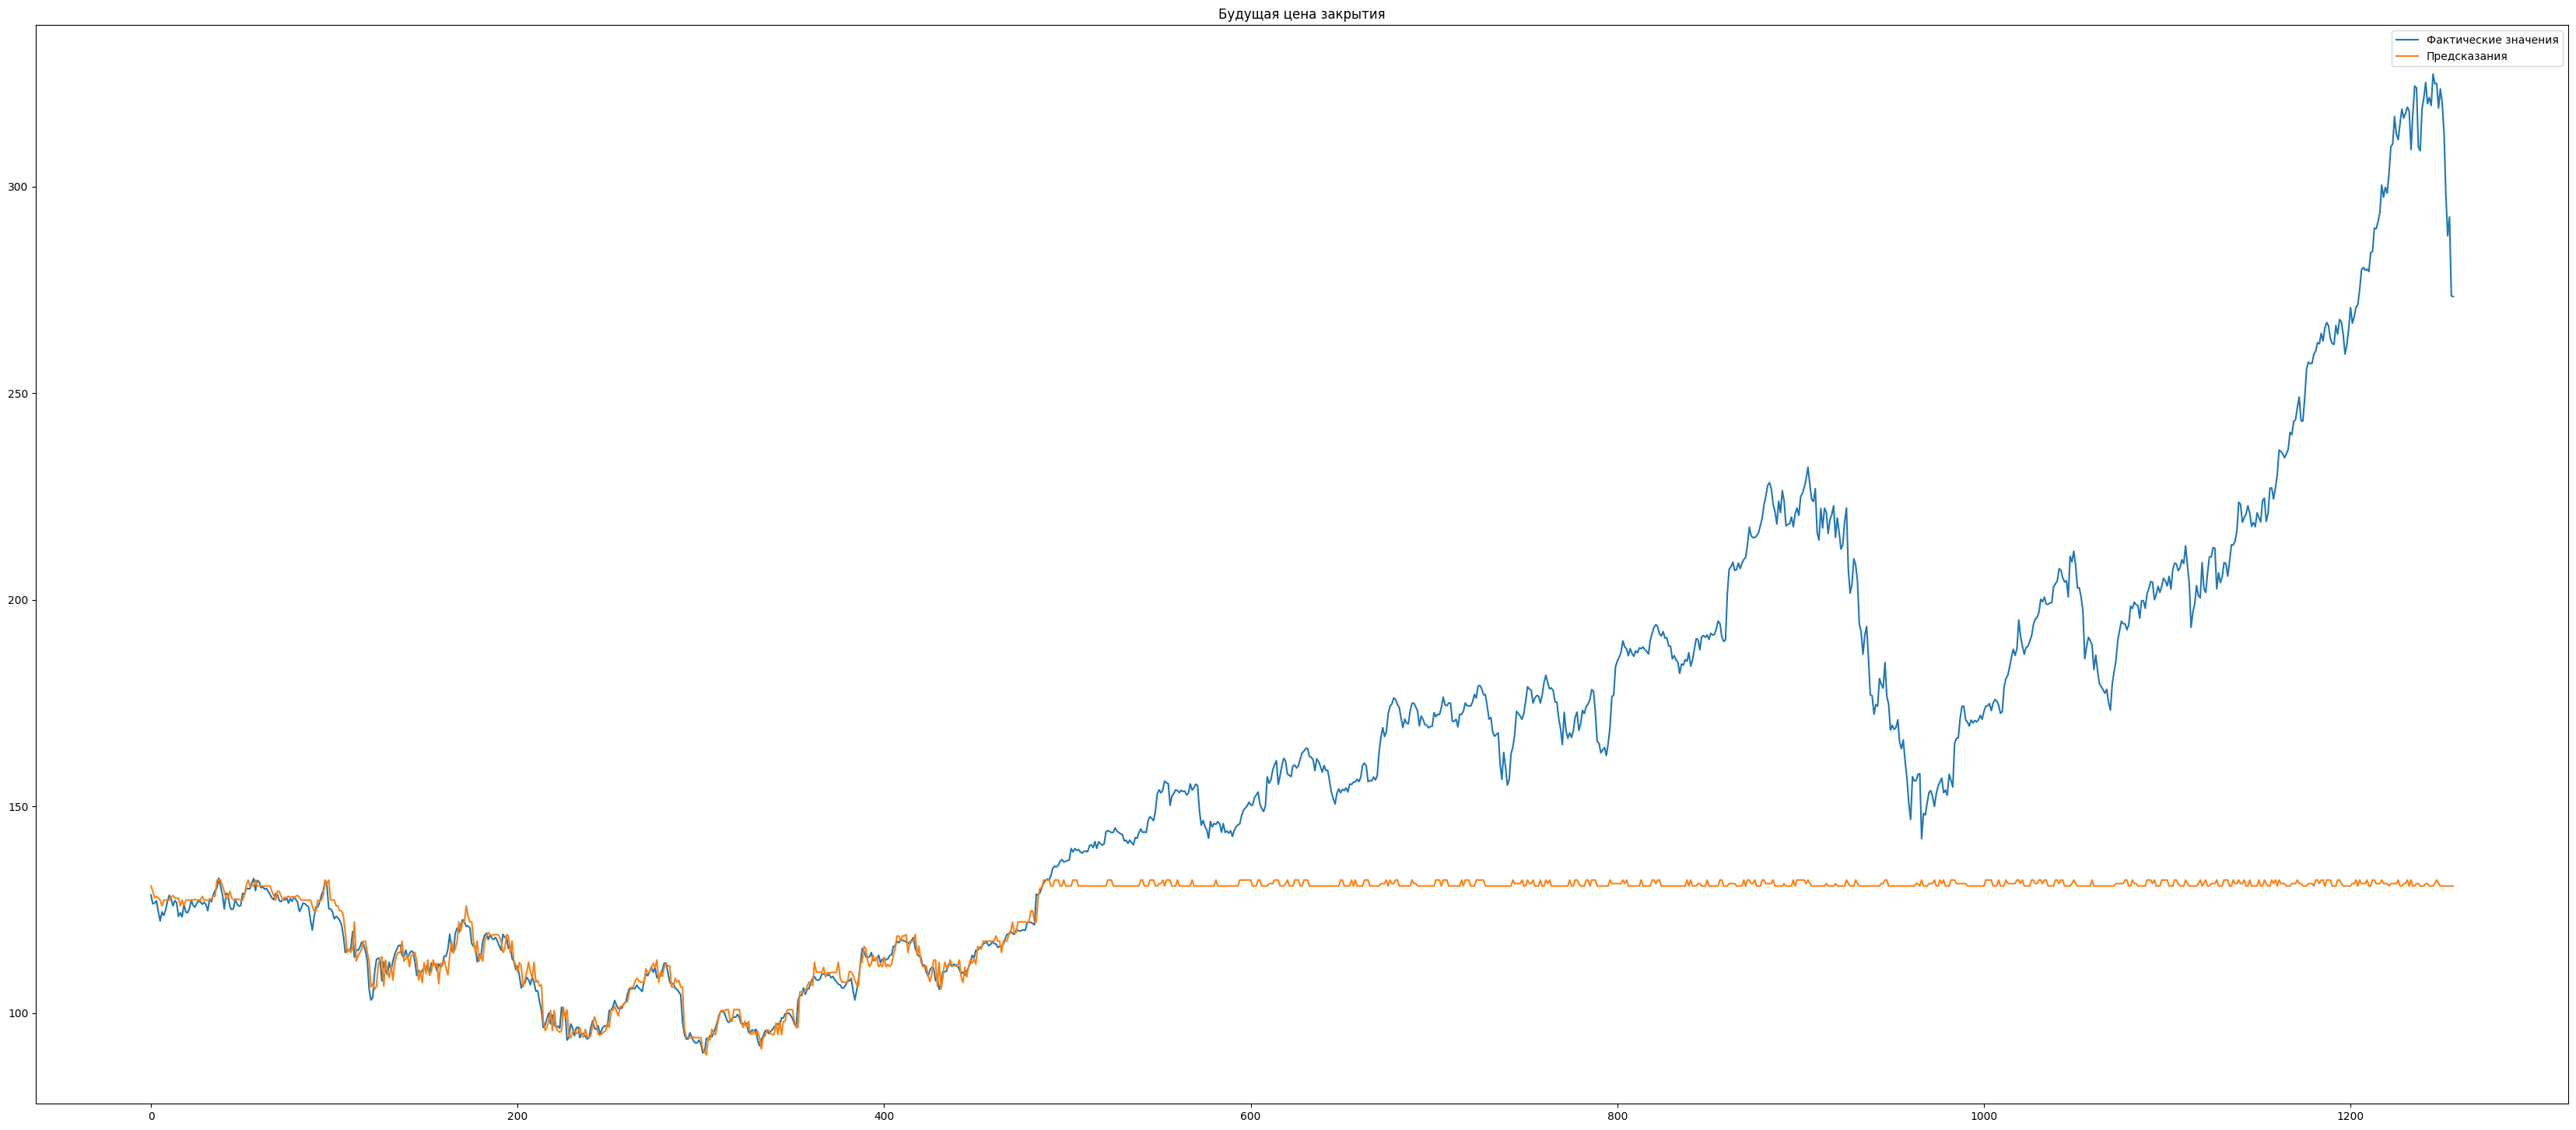

In [20]:
show_predict_on_test(y_test, gs_forest.predict(X_test), scale=scale)

# Random Search

* **Идея:** выбираем случайные комбинации гиперпараметров из заранее определённых диапазонов.
* **Плюсы:**
  * Прост в реализации.
  * Эффективнее, чем Grid Search для моделей с большим числом гиперпараметров.
  * Хорош для грубой оценки влияния гиперпараметров.
* **Минусы:**
  * Не гарантирует нахождение оптимального решения.
  * Требует большого числа итераций при сложных пространствах гиперпараметров.


In [21]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,                 # модель
    param_distributions=param_grid,     # параметры
    n_iter=40,                          # кол-во попыток (кандидатов)
    scoring='r2',                 # метрика
    cv=5,                               # K-folds для кросс валидации
    n_jobs=-1,                          # параллель на всю катушку
    verbose=3                           # кол-во информации для отображения
)

random_search.fit(X_train, y_train)

# Результаты
print("\nЛучшие параметры:")
for key, value in random_search.best_params_.items():
    print(f'{key} -> {value}')
print("\nЛучшее качество на кросс-валидации:", random_search.best_score_)
print("Точность на тесте:", random_search.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Лучшие параметры:
classifier__n_estimators -> 100
classifier__min_samples_split -> 5
classifier__min_samples_leaf -> 4
classifier__max_features -> 1.0
classifier__max_depth -> 20
classifier__criterion -> squared_error
classifier__bootstrap -> False

Лучшее качество на кросс-валидации: 0.4859904501496802
Точность на тесте: -0.2824135794721585


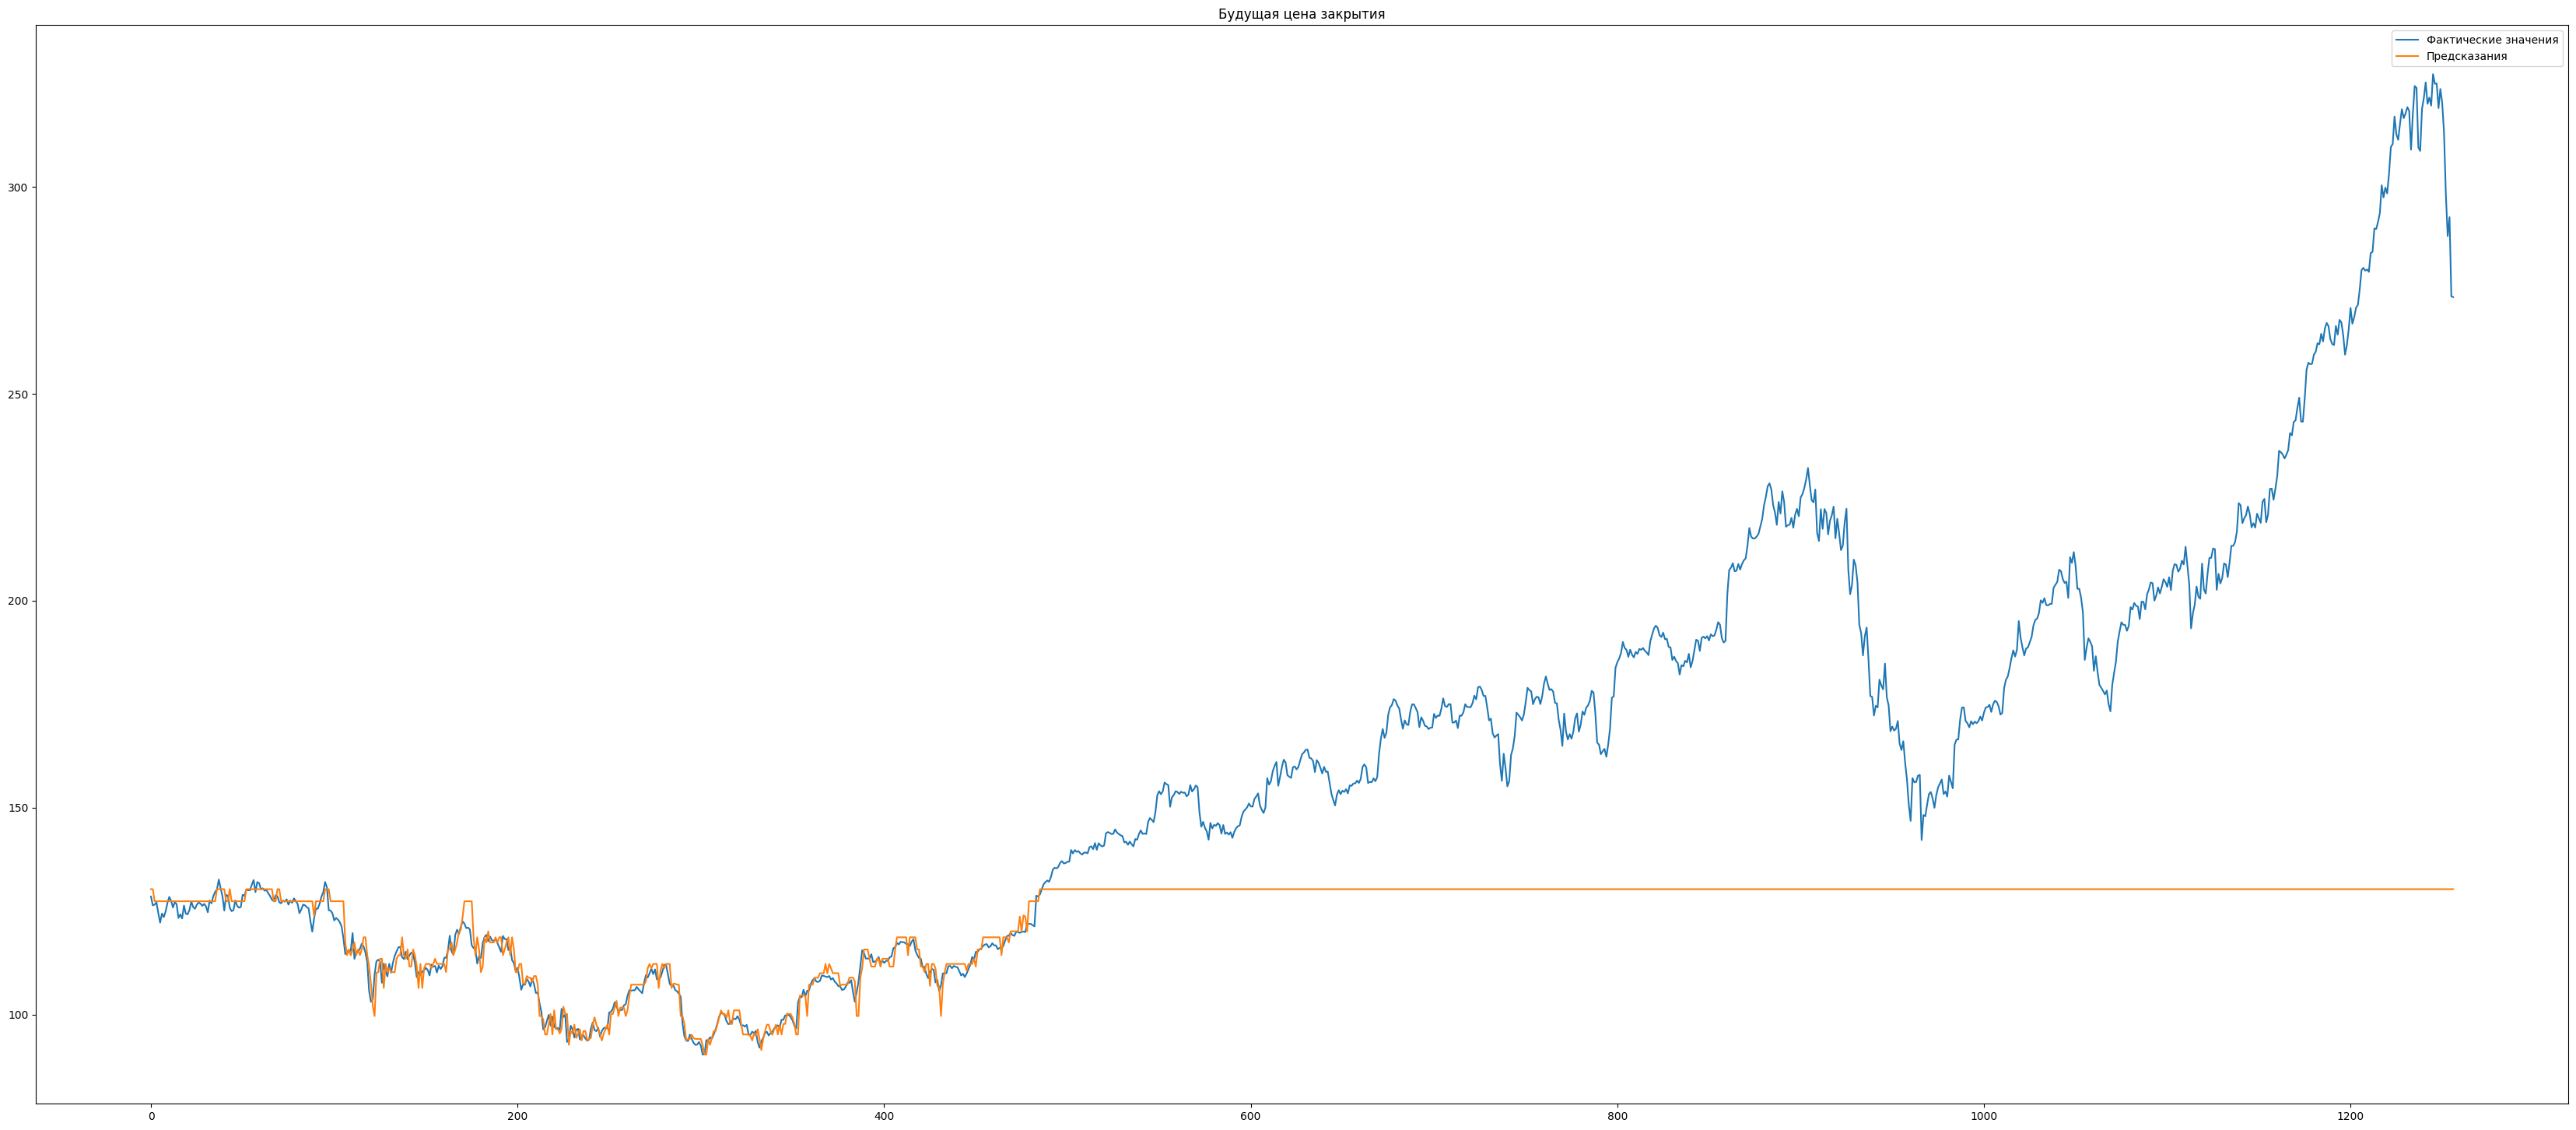

In [22]:
show_predict_on_test(y_test, random_search.predict(X_test), scale=scale)

# Байесовская оптимизация с Optuna

* **Идея:** строим вероятностную модель функции потерь и используем её, чтобы выбирать новые гиперпараметры «умнее», чем случайно.
* **Плюсы:**
  * Эффективнее Random Search при сложных пространствах гиперпараметров.
  * Балансирует *exploration* (исследование) и *exploitation* (использование лучших областей).
* **Минусы:**
  * Сложнее для понимания и настройки.
  * Требует больше зависимостей (Optuna, иногда PyTorch/Scikit-learn).

[Подробнее](https://optuna.org/)

In [23]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_dt(trial):
    # Настройка гиперпараметров для Random Forest
    n_estimators = trial.suggest_int('classifier__n_estimators', 100, 500)
    criterion = trial.suggest_categorical('classifier__criterion', ['squared_error', 'absolute_error'])
    max_depth = trial.suggest_int('classifier__max_depth', 1, 20)
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('classifier__max_features', [1.0, 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('classifier__bootstrap', [True, False])


    pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__criterion=criterion,
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__max_features=max_features,
        classifier__bootstrap=bootstrap
    )


    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    return score


# Создаём исследование
study_dt = optuna.create_study(
    direction='maximize'  # максимизирукм cross_val_score чтобы он был наибольшим
)

study_dt.optimize(
    objective_dt,
    n_trials=60,  # количество попыток
    n_jobs=-1,
)


# Лучшие параметры
print("\nЛучшие параметры Random Forest:")
for key, value in study_dt.best_params.items():
    print(f'{key} -> {value}')

pipeline.set_params(**study_dt.best_params)
pipeline.fit(X_train, y_train)
print("\nЛучшее качество на кросс-валидации:", cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean())
print("Точность Random Forest на тесте:", pipeline.score(X_test, y_test))


[I 2025-11-22 19:23:15,421] A new study created in memory with name: no-name-efd42824-c45d-413f-812a-80db1d10348d
[I 2025-11-22 19:24:17,948] Trial 10 finished with value: -0.15664465247976045 and parameters: {'classifier__n_estimators': 231, 'classifier__criterion': 'squared_error', 'classifier__max_depth': 3, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 9, 'classifier__max_features': 'log2', 'classifier__bootstrap': True}. Best is trial 10 with value: -0.15664465247976045.
[I 2025-11-22 19:24:18,373] Trial 9 finished with value: -2.7134472266952443 and parameters: {'classifier__n_estimators': 170, 'classifier__criterion': 'squared_error', 'classifier__max_depth': 1, 'classifier__min_samples_split': 18, 'classifier__min_samples_leaf': 7, 'classifier__max_features': 1.0, 'classifier__bootstrap': True}. Best is trial 10 with value: -0.15664465247976045.
[I 2025-11-22 19:24:21,345] Trial 14 finished with value: -0.5525049480442907 and parameters: {'classifier__n_e


Лучшие параметры Random Forest:
classifier__n_estimators -> 350
classifier__criterion -> squared_error
classifier__max_depth -> 9
classifier__min_samples_split -> 6
classifier__min_samples_leaf -> 1
classifier__max_features -> 1.0
classifier__bootstrap -> False

Лучшее качество на кросс-валидации: 0.46740479457331885
Точность Random Forest на тесте: -0.25667390850643246


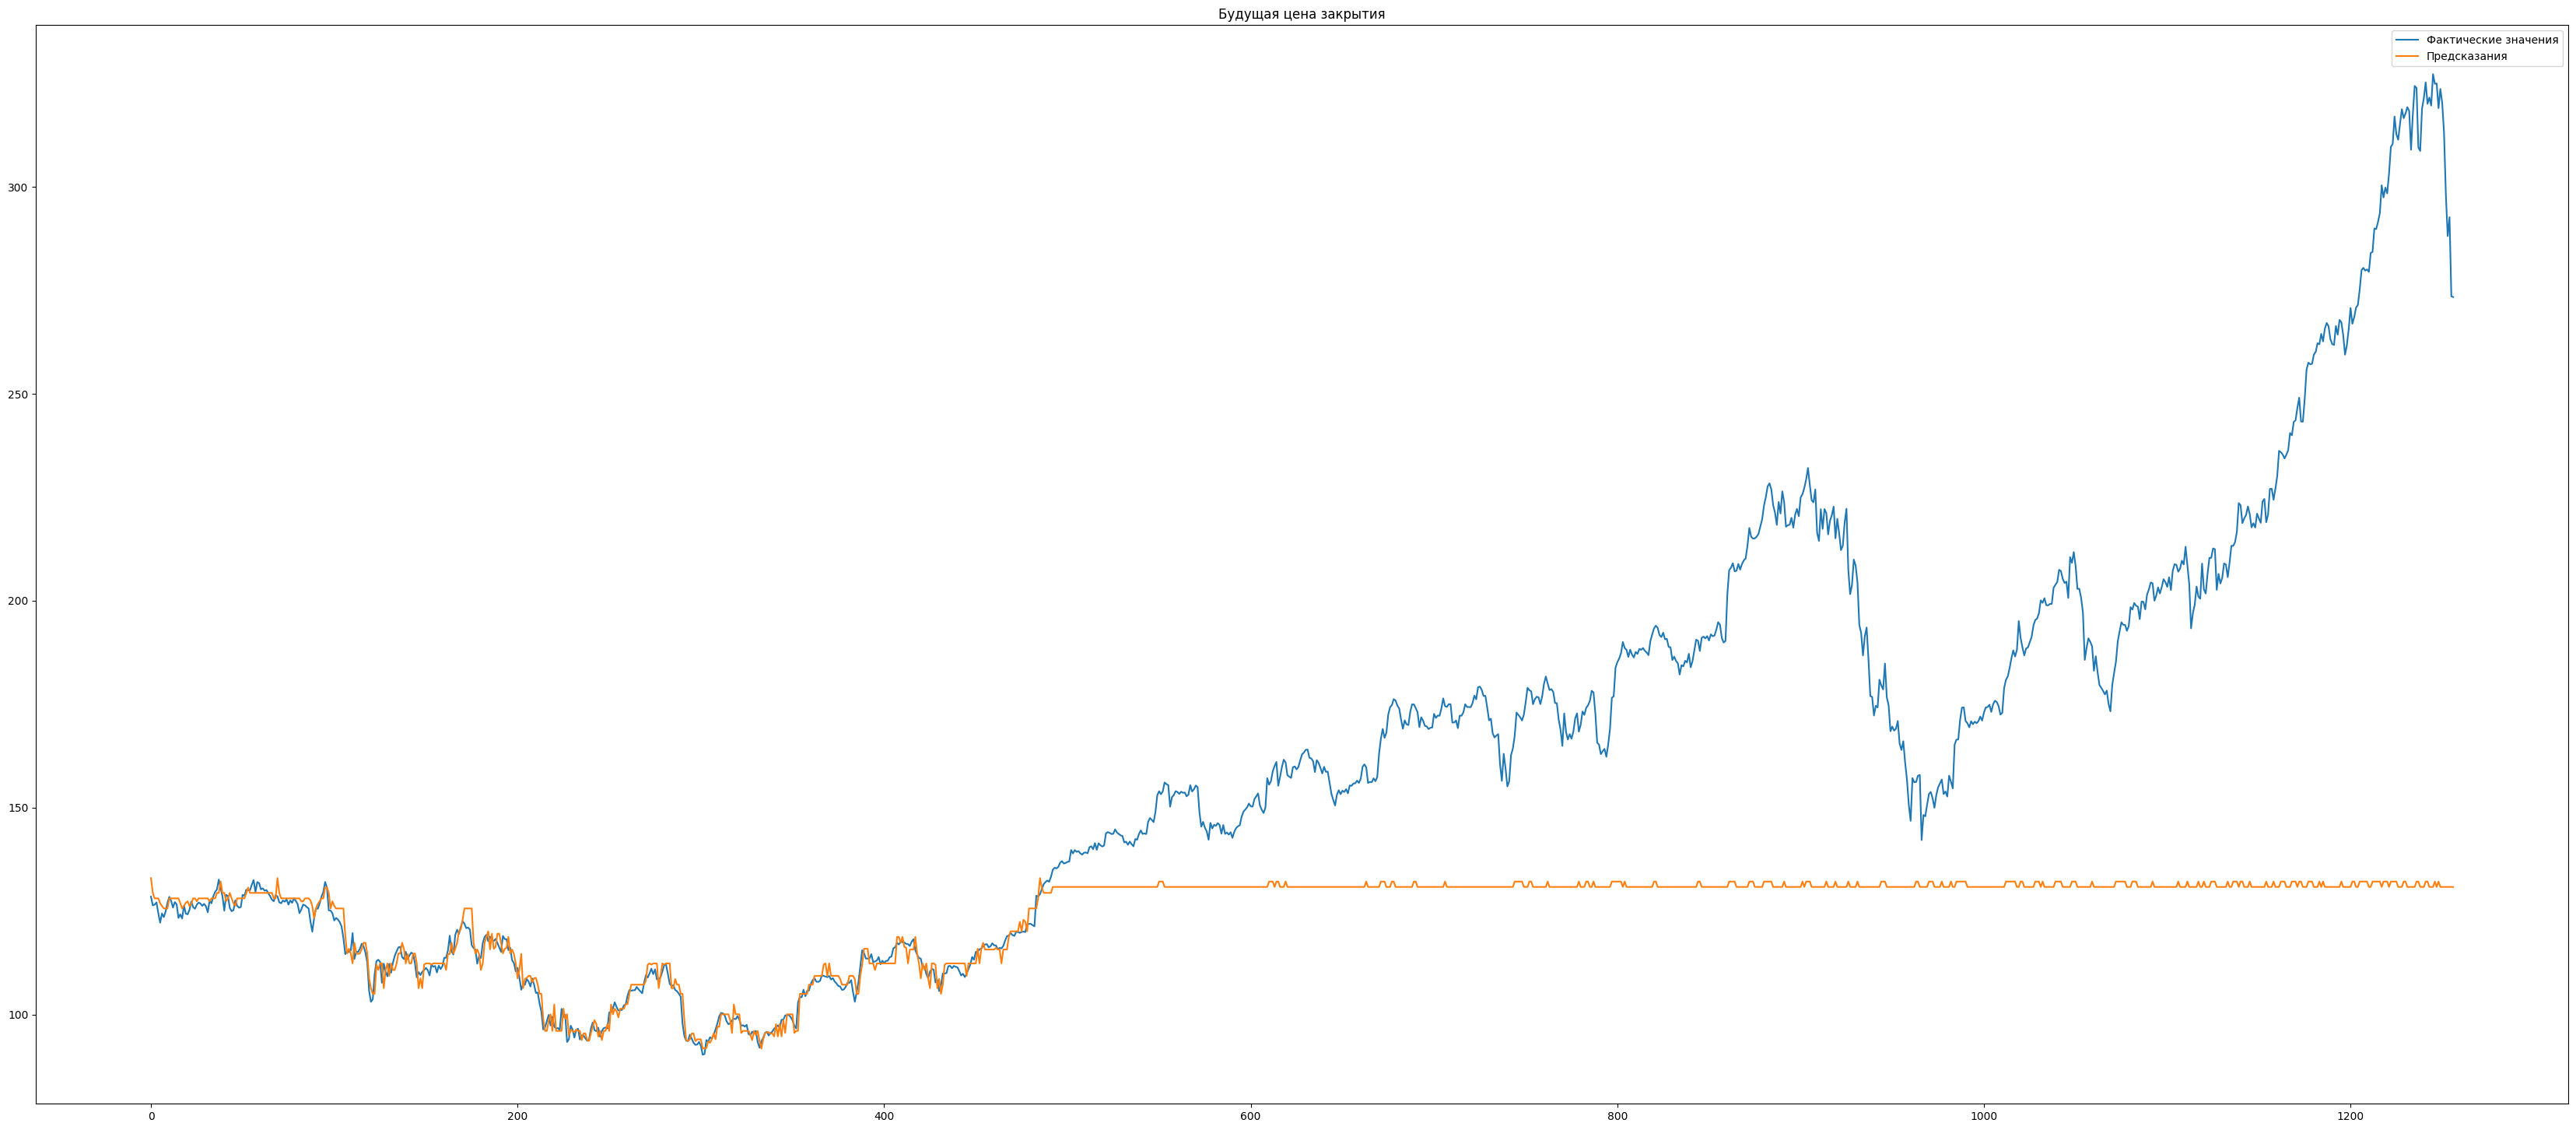

In [24]:
show_predict_on_test(y_test, pipeline.predict(X_test), scale=scale)

### Сравнение Optuna, Random search и Grid Search


In [25]:
print(f"                                   | {'Grid Search':20} | {'Random Search':20} | {'Optuna':20} |")
print(f"Лучшее качество на кросс-валидации | {gs_forest.best_score_:20} | {random_search.best_score_:20} | {cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean():20} |")
print(f"Точность на тесте                  | {gs_forest.score(X_test, y_test):20} | {random_search.score(X_test, y_test):20} | {pipeline.score(X_test, y_test):20} |")


                                   | Grid Search          | Random Search        | Optuna               |
Лучшее качество на кросс-валидации |   0.2179670962329772 |   0.4859904501496802 |  0.46740479457331885 |
Точность на тесте                  | -0.25763826109186505 |  -0.2824135794721585 | -0.25667390850643246 |


# TPOT - Automated Machine Learning (AutoML) инструмент

TPOT (Tree-based Pipeline Optimization Tool) - это библиотека автоматизированного машинного обучения (AutoML), которая использует генетические алгоритмы для оптимизации полных конвейеров машинного обучения. В отличие от Optuna и RandomizedSearchCV, которые оптимизируют только гиперпараметры существующей модели, TPOT автоматически:


* Выбирает лучшие алгоритмы машинного обучения
* Создает оптимальные preprocessing steps
* Настраивает гиперпараметры
* Строит полные конвейеры обработки данных

## Ключевые особенности TPOT

### 1. **Генетическое программирование**
TPOT использует эволюционные алгоритмы для "размножения" и "мутации" конвейеров, постепенно улучшая их качество.

### 2. **Автоматический подбор моделей**
Может выбирать между различными классификаторами/регрессорами:
- Decision Trees, Random Forest, Gradient Boosting
- SVM, KNN, Logistic Regression
- Neural Networks и другие

### 3. **Предобработка данных**
Автоматически добавляет необходимые этапы:
- StandardScaler, MinMaxScaler, RobustScaler
- PCA, SelectPercentile, VarianceThreshold
- OneHotEncoding, PolynomialFeatures

## Преимущества TPOT

- **Экономия времени** - автоматизирует рутинные задачи
- **Обнаружение неочевидных решений** - может найти нестандартные комбинации методов
- **Воспроизводимость** - генерирует готовый Python код
- **Избегает переобучения** - использует кросс-валидацию

[Подробнее](https://github.com/EpistasisLab/tpot?ysclid=mhrqdj7la9508680297)

In [26]:
!pip install tpot


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\JustDema\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
from tpot import TPOTRegressor
from sklearn.metrics import r2_score, mean_squared_error 


# Создаём TPOT-классификатор
tpot = TPOTRegressor(
    generations=5,        # количество поколений эволюций
    population_size=20,   # размер популяции
    verbose=4,            # уровень детализации вывода
    random_state=RANDOM_STATE,
    cv=5,                 # количество фолдов кросс-валидации
)



In [28]:
# Обучаем
print("Начало оптимизации с TPOT...")
tpot.fit(X_train, y_train)


Начало оптимизации с TPOT...


C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tpot\tpot_estimator\estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\distributed\node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52416 instead
  warnings.warn(
Generation:  20%|██        | 1/5 [02:11<08:47, 131.89s/it]

Generation:  1
Best mean_squared_error score: -1.6295514152388493


Generation:  40%|████      | 2/5 [03:52<05:40, 113.53s/it]

Generation:  2
Best mean_squared_error score: -1.5664787932968993


Generation:  60%|██████    | 3/5 [05:08<03:12, 96.49s/it] 

Generation:  3
Best mean_squared_error score: -1.4370283793211325


Generation:  80%|████████  | 4/5 [06:26<01:29, 89.24s/it]

Generation:  4
Best mean_squared_error score: -1.4370283793211325


Generation: 100%|██████████| 5/5 [07:28<00:00, 89.79s/it]

Generation:  5
Best mean_squared_error score: -1.4278399357893452



C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:598: UserWarning: n_components is too large: it will be set to 4
  warnings.warn(
2025-11-22 19:34:35,334 - distributed.scheduler - ERROR - Removing worker 'tcp://127.0.0.1:52424' caused the cluster to lose scattered data, which can't be recovered: {'Series-a46dafb805808eee238e7866f8cd7a2c', 'DataFrame-37c4203c11e9bef45c91f4df403aae3c'} (stimulus_id='handle-worker-cleanup-1763829275.3336957')


,search_space,<tpot.search_...002792564D490>
,scorers,['neg_mean_squared_error']
,scorers_weights,[1]
,cv,5
,other_objective_functions,[]
,other_objective_functions_weights,[]
,objective_function_names,None
,bigger_is_better,True
,categorical_features,None
,memory,None
,preprocessing,False


In [29]:
# Оценка качества
y_pred = tpot.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 на тестовой выборке: {test_r2:.4f}")
print(f"RMSE на тестовой выборке: {test_rmse:.4f}")

# Лучшие параметры и конвейер
print("\nЛучший конвейер:")
print(tpot.fitted_pipeline_)

R2 на тестовой выборке: 0.9972
RMSE на тестовой выборке: 2.7215

Лучший конвейер:
Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('selectfwe', SelectFwe(alpha=0.0001671645476)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('fastica',
                                                                                 FastICA(algorithm=np.str_('parallel'),
                                                                                         n_components=5,
                                                                                         random_state=34))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transforme...
                                                                

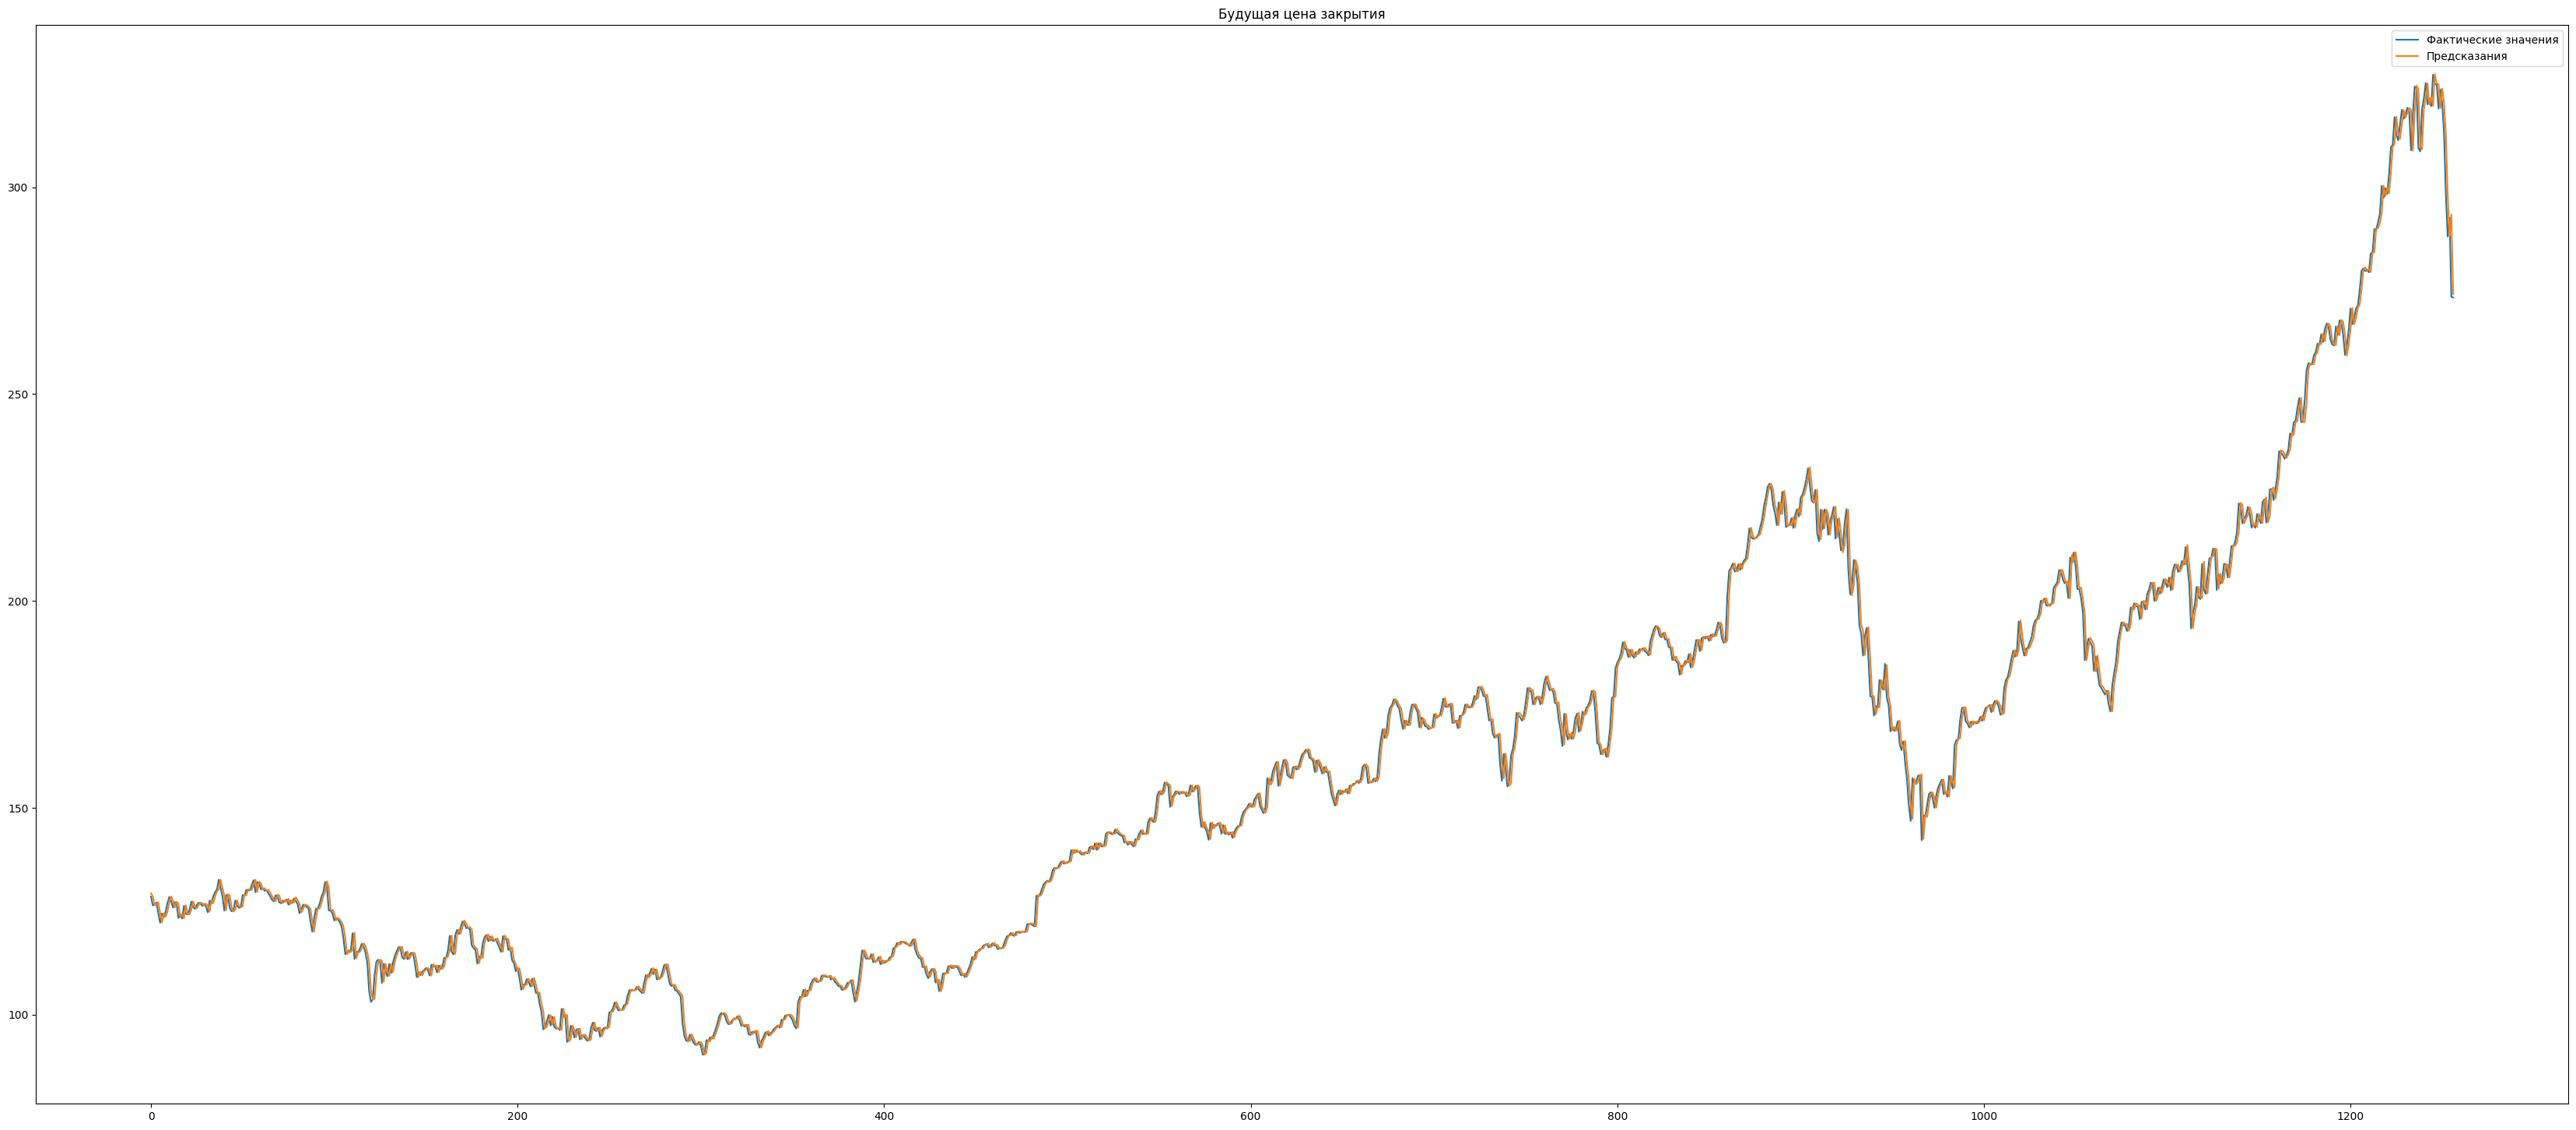

In [30]:
show_predict_on_test(y_test, y_pred, scale=scale)

# Сравнение

| Метод | Что оптимизирует | Автоматизация | Время | Качество |
|-------|------------------|---------------|-------|----------|
| **Optuna** | Гиперпараметры модели | Средняя | Среднее | Высокое |
| **RandomizedSearchCV** | Гиперпараметры модели | Низкая | Быстрое | Среднее |
| **TPOT** | Полный конвейер + модели | Полная | Длительное | Очень высокое |

In [31]:
# !pip install lime 
# !pip install shap

In [32]:
import lime
import lime.lime_tabular

# Использование LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X.columns, 
    mode='regression',  # ← ИЗМЕНИТЬ НА 'regression'
    discretize_continuous=True
    )


i = 33  # пример для интерпретации
exp = explainer.explain_instance(X_test.iloc[i].values, tpot.predict, num_features=5)

exp.as_list()

C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(


[('Close > 84.50', 37.17546803328449),
 ('High > 85.25', 5.424198370939841),
 ('Open > 84.57', -4.8249935417053695),
 ('Low > 83.63', 4.141517223429169),
 ('0.28 < Price_Momentum <= 1.47', -0.8448405902176134)]

 98%|===================| 1236/1257 [00:37<00:00]        

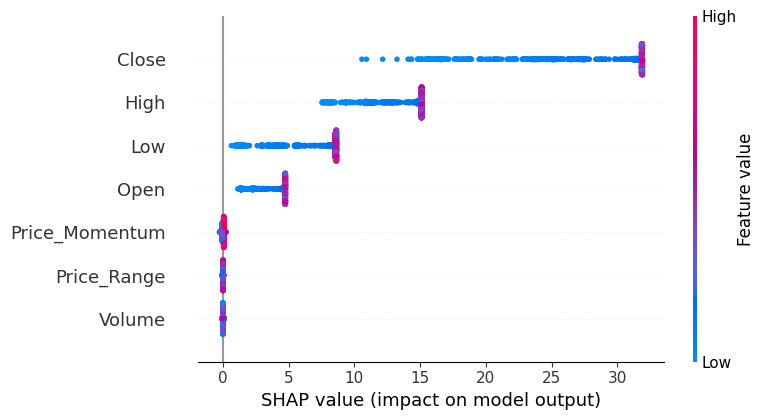

In [33]:
import shap


# Использование SHAP для случайного леса
explainer = shap.Explainer(model_forest, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


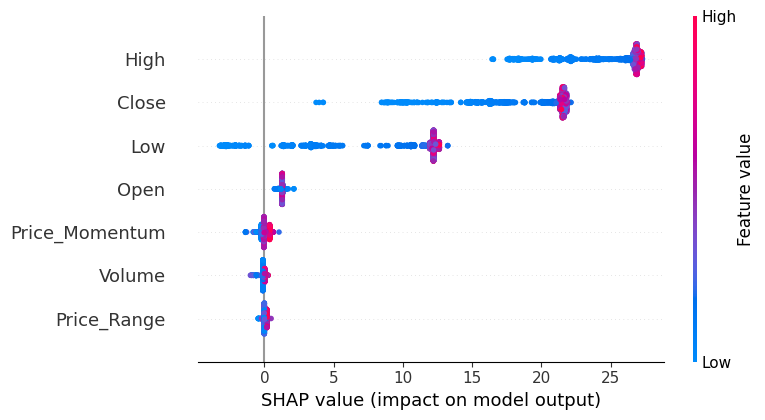

In [34]:
import shap

# Получаем модель из пайплайна
model = pipeline.named_steps['classifier']

# Для tree-based моделей лучше использовать TreeExplainer
explainer = shap.TreeExplainer(model)

# Получаем предобработанные данные
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_test_scaled)

# Визуализация
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

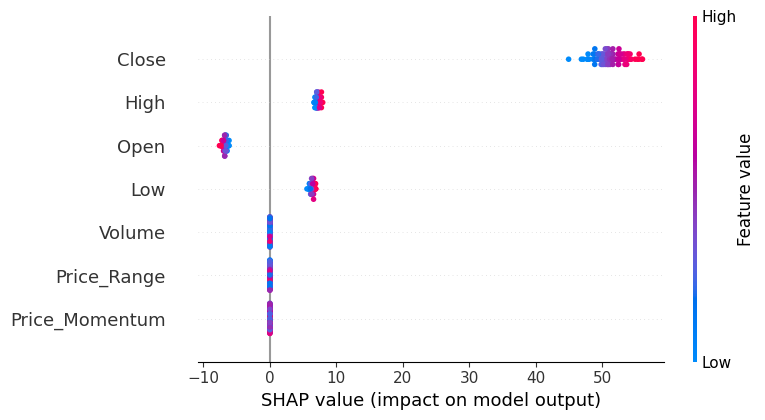

In [35]:
# Получаем лучшую модель
best_model = tpot.fitted_pipeline_

# Создаем функцию-обертку для предсказаний
def model_predict(X):
    return best_model.predict(X)

# Используем небольшую подвыборку для фона (для скорости)
background = shap.sample(X_train, 50)  # 50 samples for background

# Создаем explainer с использованием функции предсказания
explainer = shap.Explainer(model_predict, background)

# Вычисляем SHAP значения для тестовой выборки (можно взять подвыборку для скорости)
shap_values = explainer(X_test[:100])  # первые 100 samples

# Визуализируем результаты
shap.summary_plot(shap_values, X_test[:100])